In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% ! important; }<style>"))

In [2]:
import matplotlib
%matplotlib notebook

import numpy as np
from astropy.io import fits
import matplotlib.pylab as plt
import os

from matplotlib import rcParams
import matplotlib as mpl

from matplotlib.ticker import MultipleLocator, FixedLocator
from matplotlib.gridspec import GridSpec
from astropy.table import Table

### some functions

In [10]:
from kapteyn import kmpfit


def poly4(p, x):
    a0, a1, a2, a3, a4 = p
    return a0+a1*x+a2*x**2+a3*x**3+a4*x**4


def resd_poly4(p, data):
    x, y, yerr = data
    model = poly4(p, x)
    return (y-model)/yerr


def poly3(p, x):
    a0, a1, a2, a3 = p
    return a0+a1*x+a2*x**2+a3*x**3


def resd_poly3(p, data):
    x, y, yerr = data
    model = poly3(p, x)
    return (y-model)/yerr


def poly5(p, x):
    a0, a1, a2, a3, a4, a5 = p
    return a0+a1*x+a2*x**2+a3*x**3+a4*x**4+a5*x**5


def resd_poly5(p, data):
    x, y, yerr = data
    model = poly5(p, x)
    return (y-model)/yerr


def polyfit(x, y, yerr, polyorder):

    fitdata = [x, y, yerr]
    if polyorder not in [3, 4, 5]:
        raise ValueError("the polynomial orders options: 3,4,5")
    else:
        if polyorder == 3:
            resd_poly = resd_poly3
            polymodel = poly3
            params0 = [1, 0, 0, 0]
        if polyorder == 4:
            resd_poly = resd_poly4
            polymodel = poly4
            params0 = [1, 0, 0, 0, 0]
        if polyorder == 5:
            resd_poly = resd_poly5
            polymodel = poly5
            params0 = [1, 0, 0, 0, 0, 0]

    fitobj = kmpfit.Fitter(residuals=resd_poly, data=fitdata)

    # print "Input fit data: "
    # print fitdata
    fitobj.fit(params0=params0)

    return fitobj

def single_gaussian(p, x):
    '''
    INPUTS:
            p: a sequence of parameters, amplitude, center, dispersion and zerolevel
            x: indepedent variable
    '''

    A, mu, sigma, zerolev = p
    return (A*np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma)) + zerolev)


def multi_gaussians(p, x, ncomp):
    '''
    INPUTS:
            p: a sequence of parameters, (amplitude, center, dispersion)*ncomp  and zerolevel
            x: indepedent variable
            ncomp: components number
    '''

    y = 0.0
    zerolev = p[-1]

    for i in range(ncomp):
        A, mu, sigma = p[i*3:(i+1)*3]
        y += A*np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma))

    return y + zerolev


def residuals_sG(p, data):
    '''
    multiple gaussians 
    '''
    x, y, yerr = data
    model = single_gaussian(p, x)
    return (y-model)/yerr


def spec_1gaussian_fitting(x, y, yerr, params0, display=True, fix_par_inds=None, show_yerr=False, verbose=1):
    '''
    Two components gaussian fitting
    '''
    fitdata = [x, y, yerr]
    fitobj = kmpfit.Fitter(residuals=residuals_sG, data=fitdata)

    if fix_par_inds is not None:
        fitobj.parinfo = []
        for param in params0:
            fitobj.parinfo.append({})
        for ind in fix_par_inds:
            print(("parameter #%s will be fixed" % ind))
            fitobj.parinfo[ind]['fixed'] = True
            print((fitobj.parinfo))

    fitobj.fit(params0=params0)

    if (fitobj.status <= 0):
        print(('error message =', fitobj.errmsg))
        raise SystemExit

    if verbose:
        print(("Params:        ", fitobj.params))
        print(("Errors from covariance matrix         : ", fitobj.xerror))
        print(("Uncertainties assuming reduced Chi^2=1: ", fitobj.stderr))
        print(("Chi^2 min:     ", fitobj.chi2_min))

    pfits = fitobj.params
    stderrs = fitobj.stderr

    if display:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.plot(x, y, 'b', label='data')
        if show_yerr:
            ax.errorbar(x, y, yerr=yerr, fmt='b.', label='data')
        flux_fit = single_gaussian(pfits, x)

        p1 = [pfits[0], pfits[1], pfits[2], pfits[-1]]
        comp1 = single_gaussian(p1, x)

        ax.plot(x, comp1, 'co', label='component 1')

        ax.plot(x, flux_fit, 'r', linewidth=2, label='all')

        plt.legend()
        plt.show()

    return pfits, stderrs


def residuals_twoG(p, data):
    ''' 
    multiple gaussians 
    '''
    x, y, yerr = data
    model = multi_gaussians(p, x, 2)
    return (y-model)/yerr


def spec_2gaussians_fitting(x, y, yerr, params0, display=True, baselinefixed=False):
    '''
    Two components gaussian fitting
    '''
    fitdata = [x, y, yerr]
    fitobj = kmpfit.Fitter(residuals=residuals_twoG, data=fitdata)
    if baselinefixed:
        fitobj.parinfo = [{'fixed': False}]*6+[{'fixed': True}]
    fitobj.fit(params0=params0)

    if (fitobj.status <= 0):
        print(('error message =', fitobj.errmsg))
        raise SystemExit

    print(("Params:        ", fitobj.params))
    print(("Errors from covariance matrix         : ", fitobj.xerror))
    print(("Uncertainties assuming reduced Chi^2=1: ", fitobj.stderr))
    print(("Chi^2 min:     ", fitobj.chi2_min))

    pfits = fitobj.params
    stderrs = fitobj.stderr

    if display:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.plot(x, y, 'b', label='data')
        flux_fit = multi_gaussians(pfits, x, 2)

        p1 = [pfits[0], pfits[1], pfits[2], pfits[-1]]
        p2 = [pfits[3], pfits[4], pfits[5], pfits[-1]]
        comp1 = single_gaussian(p1, x)
        comp2 = single_gaussian(p2, x)

        ax.plot(x, comp1, 'co', label='component 1')
        ax.plot(x, comp2, 'ko', label='component 2')

        ax.plot(x, flux_fit, 'r', linewidth=2, label='all')

        plt.legend()
        plt.show()

    return pfits, stderrs


def single_lorentzian(p, x):
    h, c, w, zerolev = p
    return h/(1+((x-c)/w)**2)+zerolev


def residuals_sL(p, data):
    ''' 
    multiple gaussians 
    '''
    x, y, yerr = data
    model = single_lorentzian(p, x)
    return (y-model)/yerr


def spec_lorentzian_fitting(x, y, yerr, params0, display=True, fix_par_inds=None, show_yerr=False):
    fitdata = [x, y, yerr]
    fitobj = kmpfit.Fitter(residuals=residuals_sL, data=fitdata)
    if fix_par_inds is not None:
        fitobj.parinfo = []
        for param in params0:
            fitobj.parinfo.append({})
        for ind in fix_par_inds:
            print("parameter #%s will be fixed" % ind)
            fitobj.parinfo[ind]['fixed'] = True
            print(fitobj.parinfo)

    fitobj.fit(params0=params0)

    if (fitobj.status <= 0):
        print(('error message =', fitobj.errmsg))
        raise SystemExit

    print(("Params:        ", fitobj.params))
    print(("Errors from covariance matrix         : ", fitobj.xerror))
    print(("Uncertainties assuming reduced Chi^2=1: ", fitobj.stderr))
    print(("Chi^2 min:     ", fitobj.chi2_min))

    pfits = fitobj.params
    stderrs = fitobj.stderr

    if display:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.plot(x, y, 'b', label='data')
        if show_yerr:
            ax.errorbar(x, y, yerr=yerr, fmt='b.', label='data')
        flux_fit = single_lorentzian(pfits, x)

        p1 = [pfits[0], pfits[1], pfits[2], pfits[-1]]
        comp1 = single_lorentzian(p1, x)

        ax.plot(x, comp1, 'co', label='component 1')

        ax.plot(x, flux_fit, 'r', linewidth=2, label='all')

        plt.legend()
        plt.show()

    return pfits, stderrs


def gas_emission_and_stellar_absorption(p, x):
    ''' 
    INPUTS:
            p: a sequence of parameters, amplitude, center, dispersion and zerolevel
            x: indepedent variable
    '''

    A, mu, sigma, h, c, w, zerolev = p
    return A*np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma)) + zerolev + h/(1+((x-c)/w)**2)


def residuals_lorentzian_gaussian(p, data):
    ''' 
    multiple gaussians 
    '''
    x, y, yerr = data
    model = gas_emission_and_stellar_absorption(p, x)
    return (y-model)/yerr


def spec_emission_and_absorption_fitting(x, y, yerr, params0, display=True, fix_par_inds=None, show_yerr=False):
    fitdata = [x, y, yerr]
    fitobj = kmpfit.Fitter(
        residuals=residuals_lorentzian_gaussian, data=fitdata)
    if fix_par_inds is not None:
        fitobj.parinfo = []
        for param in params0:
            fitobj.parinfo.append({})
        for ind in fix_par_inds:
            print("parameter #%s will be fixed" % ind)
            fitobj.parinfo[ind]['fixed'] = True
            print(fitobj.parinfo)

    fitobj.fit(params0=params0)

    if (fitobj.status <= 0):
        print('error message =', fitobj.errmsg)
        raise SystemExit

    print("Params:        ", fitobj.params)
    print("Errors from covariance matrix         : ", fitobj.xerror)
    print("Uncertainties assuming reduced Chi^2=1: ", fitobj.stderr)
    print("Chi^2 min:     ", fitobj.chi2_min)

    pfits = fitobj.params
    stderrs = fitobj.stderr

    if display:
        fig, ax = plt.subplots(figsize=(8, 8))
        if show_yerr:
            ax.errorbar(x, y, yerr=yerr, fmt='b.', label='data')
        else:
            ax.plot(x, y, 'b', label='data')
        flux_fit = gas_emission_and_stellar_absorption(pfits, x)

        p1 = [pfits[0], pfits[1], pfits[2], 0]
        comp1 = single_gaussian(p1, x)
        ax.plot(x, comp1, 'c', label='gas emission')
        p2 = [pfits[3], pfits[4], pfits[5], pfits[-1]]
        comp2 = single_lorentzian(p2, x)
        ax.plot(x, comp2, 'g', label='stellar absorption')

        ax.plot(x, flux_fit, 'r', linewidth=2, label='all')

        plt.legend()
        plt.show()

    return pfits, stderrs


def multi_gaussians(p, x, ncomp):
    ''' 
    INPUTS:
            p: a sequence of parameters, (amplitude, center, dispersion)*ncomp  and zerolevel
            x: indepedent variable
            ncomp: components number
    '''

    y = 0.0
    zerolev = p[-1]

    for i in range(ncomp):
        A, mu, sigma = p[i*3:(i+1)*3]
        y += A*np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma))

    return y + zerolev


def residuals_three(p, data):
    ''' 
    multiple gaussians 
    '''
    x, y, yerr = data
    model = multi_gaussians(p, x, 3)
    return (y-model)/yerr






def spec_3gaussians_fitting(x, y, yerr, params0, display=True, fix_par_inds=None):
    ''' 
    three components gaussian fitting
    '''
    fitdata = [x, y, yerr]
    fitobj = kmpfit.Fitter(residuals=residuals_three, data=fitdata)
    if fix_par_inds is not None:
        fitobj.parinfo = []
        for param in params0:
            fitobj.parinfo.append({})
        for ind in fix_par_inds:
            print("parameter #%s will be fixed" % ind)
            fitobj.parinfo[ind]['fixed'] = True
            print(fitobj.parinfo)

    fitobj.parinfo[0]['limits'] = (0,None)
    fitobj.parinfo[3]['limits'] = (0,None)
    fitobj.parinfo[6]['limits'] = (0,None)
    
    print(fitobj.parinfo)
            
    fitobj.fit(params0=params0)

    if (fitobj.status <= 0):
        print('error message =', fitobj.errmsg)
        raise SystemExit

    print("Params:        ", fitobj.params)
    print("Errors from covariance matrix         : ", fitobj.xerror)
    print("Uncertainties assuming reduced Chi^2=1: ", fitobj.stderr)
    print("Chi^2 min:     ", fitobj.chi2_min)

    pfits = fitobj.params
    stderrs = fitobj.stderr

    if display:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.plot(x, y, 'b', label='data')
        flux_fit = multi_gaussians(pfits, x, 3)

        p1 = [pfits[0], pfits[1], pfits[2], pfits[-1]]
        p2 = [pfits[3], pfits[4], pfits[5], pfits[-1]]
        p3 = [pfits[6], pfits[7], pfits[8], pfits[-1]]
        comp1 = single_gaussian(p1, x)
        comp2 = single_gaussian(p2, x)
        comp3 = single_gaussian(p3, x)
        ax.plot(x, comp1, 'co', label='component 1')
        ax.plot(x, comp2, 'ko', label='component 2')
        ax.plot(x, comp3, 'mo', label='component 3')
        ax.plot(x, flux_fit, 'r', linewidth=2, label='all')

        plt.legend()
        plt.show()

    return pfits, stderrs




In [11]:
def sigma_clipping(data, sig=3, meanfunc=np.median, display_result=False):
    """
    Identify outliers considering the mean (if meanfunc=np.mean) or median (if meanfunc=np.median) value and 3 sigma (3*stdev),
    iterating until convergence.
    """
    last_total = len(data)
    # First iteration
    stdev = np.std(data)
    diff = data - meanfunc(data)
    sfilter = np.abs(diff) < sig*stdev
    current_total = len(data[sfilter])
    # Continue iterating until convergence (no more points are removed)
    while last_total > current_total:
        # print current_total, stdev
        last_total = current_total
        stdev = np.std(data[sfilter])
        diff = data - meanfunc(data[sfilter])
        sfilter = np.abs(diff) < sig*stdev
        current_total = len(data[sfilter])

    if display_result:
        import matplotlib.pylab as plt

        plt.plot(data, 'ko', label='Original')
        plt.plot(data[sfilter], 'ro', label='after clipping')
        plt.legend()
        plt.show()

    return data[sfilter], sfilter, stdev

def binning_with_sigma_clipping(x, y, dt, yerr=None,  useBinCenter=True, useMeanX=False,  removeEmpty=True, removeNoError=False):
    '''
    same algorithm with simple binning in PyAstronomy, but perform signal clipping in each bin first
    '''

    x0 = np.min(x)
    inWhichBin = np.floor((x-x0)/dt)

    nbins = int(np.max(inWhichBin)) + 1
    bwd = np.unique(inWhichBin)

    print(nbins)

    result = np.empty((nbins, 4))
    result[:] = np.NAN

    result[:, 0] = x0 + np.arange(nbins)*dt

    if useBinCenter:
        result[:, 0] += 0.5*dt

    for b in bwd:
        b = int(b)
        # print result

        # print b
        indi = np.where(inWhichBin == b)[0]
        # print indi
        # print result[b,3]
        result[b, 3] = len(indi)

        y_thisbin = y[indi]

        y_clipped, safeindex, stddev = sigma_clipping(y_thisbin, sig=3, meanfunc=np.mean, display_result=False)

        result[b, 1] = np.mean(y_clipped)

        if useMeanX:
            result[b, 0] = np.mean(x[indi])

        if useMeanX:
            result[b, 0] = np.mean(x[indi])
        if yerr is None:
            # No errors on data points are given
            if len(indi) > 1:
                result[b, 2] = np.std(y[indi]) / np.sqrt(result[b, 3])
            else:
              # No error if there is only a single point in the bin
                result[b, 2] = np.NAN
        else:
            # There are errors on the data points
            # Use error propagation
            result[b, 2] = np.sqrt(np.sum(yerr[indi]**2)) / result[b, 3]

    if removeEmpty:
        # Remove bins without data points in it
        indi = np.where(np.invert(np.isnan(result[:, 1])))[0]
        result = result[indi, :]

    if removeNoError:
        # Remove bins for which no error can be given
        indi = np.where(np.invert(np.isnan(result[:, 2])))[0]
        result = result[indi, :]

    return result




## load the spectra

In [3]:
z = 0.0055
z_22jli = 0.0055

In [4]:
#prepare spectral template

import pickle

#if previous saved result available
outfile = '../data/spectra/2022jli.20230301.p'
with open(outfile, 'rb') as fp:
    specs_22jli = pickle.load(fp)

spectable = specs_22jli['spectable']
spectable.sort('phase')



In [5]:
spectable.show_in_notebook()

idx,specname,phase,bump_phase,date,jd,specfile,telescope,instrument,exptime
0,psh0511,5.973749999888241,11.696212311275303,2022-05-11.143,2459710.64375,./spectra/tns/tns_2022jli_2022-05-11_03-27-00_Other_Other_PSH.dat,other,other,999
1,efosc0524,19.247025463264436,12.469487774651498,2022-05-24.417,2459723.917025463,./spectra/tns/tns_2022jzy_2022-05-24_10-00-31_ESO-NTT_EFOSC2-NTT_ePESSTO+.asci,NTT,EFOSC2,999
2,sedm0629,55.253703703638166,10.976166015025228,2022-06-29.423,2459759.9237037036,./spectra/fritz/spec_auto_robot_lstep1__crr_b_ifu20220629_10_10_08_ZTF22aapubuy.txt,P60,SEDM,1800
3,sedm0707,63.254224536940455,6.4766868483275175,2022-07-07.424,2459767.924224537,./spectra/fritz/spec_auto_robot_lstep1__crr_b_ifu20220707_10_10_53_ZTF22aapubuy.txt,P60,SEDM,1800
4,sedm0719,75.28391203703359,6.00637434842065,2022-07-19.453,2459779.953912037,./spectra/fritz/spec_auto_robot_lstep1__crr_b_ifu20220719_10_53_38_ZTF22aapubuy.txt,P60,SEDM,1800
5,sedm0726,82.16870370367542,0.39116601506248116,2022-07-26.338,2459786.8387037036,./spectra/fritz/spec_auto_robot_lstep1__crr_b_ifu20220726_08_07_44_ZTF22aapubuy.txt,P60,SEDM,1800
6,sedm0804,91.24891203688458,9.471374348271638,2022-08-04.418,2459795.918912037,./spectra/fritz/spec_auto_robot_lstep1__crr_b_ifu20220804_10_03_14_ZTF22aapubuy.txt,P60,SEDM,1800
7,not0806,93.02682870393619,11.249291015323251,2022-08-06.196,2459797.696828704,./spectra/fritz/spectrum_1d.ascii,NOT,ALFOSC,999
8,sedm0811,98.14078703708947,3.863249348476529,2022-08-11.310,2459802.810787037,./spectra/fritz/spec_auto_robot_lstep1__crr_b_ifu20220811_07_27_32_ZTF22aapubuy.txt,P60,SEDM,1800
9,sedm0816,103.11894675949588,8.841409070882946,2022-08-16.288,2459807.7889467594,./spectra/fritz/spec_auto_robot_lstep1__crr_b_ifu20220816_06_56_05_ZTF22aapubuy.txt,P60,SEDM,1800


In [12]:
def OI_Halpha_model(p, x):
    return multi_gaussians(p, x, 3) + single_gaussian([p[0]/3., p[1]+63, p[2], 0],x)


def residual_OI_region(p, data):

    x, y, yerr = data
    model = multi_gaussians(p, x, 3) + single_gaussian([p[0]/3., p[1]+63, p[2], 0],x)
    return (y-model)/yerr


def spec_OI6300_fitting(x, y, yerr, params0, display=True, baselinefixed=False, fix_par_inds=None):
    '''
    three components gaussian fitting
    the first is OI6300+6363
    the second is Halpha 
    the third is one unidentified feature blueward of OI
    '''
    fitdata = [x, y, yerr]
    fitobj = kmpfit.Fitter(residuals=residual_OI_region, data=fitdata)
    
    fitobj.parinfo = [{},{},{}, {},{},{}, {},{},{}, {}]
    fitobj.parinfo[0]['limits'] = (0,None)
    fitobj.parinfo[3]['limits'] = (0,None)
    fitobj.parinfo[6]['limits'] = (0,None)
    
    if fix_par_inds is not None:
        fitobj.parinfo = []
        for param in params0:
            fitobj.parinfo.append({})
        for ind in fix_par_inds:
            print("parameter #%s will be fixed" % ind)
            fitobj.parinfo[ind]['fixed'] = True
            print(fitobj.parinfo)

    if baselinefixed:
        fitobj.parinfo[9]['fixed'] = True 

    print(fitobj.parinfo)
    fitobj.fit(params0=params0)

    if (fitobj.status <= 0):
        print(('error message =', fitobj.errmsg))
        raise SystemExit

    print(("Params:        ", fitobj.params))
    print(("Errors from covariance matrix         : ", fitobj.xerror))
    print(("Uncertainties assuming reduced Chi^2=1: ", fitobj.stderr))
    print(("Chi^2 min:     ", fitobj.chi2_min))

    pfits = fitobj.params
    stderrs = fitobj.stderr

    if display:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.plot(x, y, 'b', label='data')
        flux_fit = OI_Halpha_model(pfits, x)

        p1 = [pfits[0], pfits[1], pfits[2], pfits[-1]]
        p1_plus = [pfits[0]/3.0, pfits[1]+63, pfits[2], pfits[-1]]
        p2 = [pfits[3], pfits[4], pfits[5], pfits[-1]]
        p3 = [pfits[6], pfits[7], pfits[8], pfits[-1]]
        comp1 = single_gaussian(p1, x)
        comp1_plus = single_gaussian(p1_plus, x)
        comp2 = single_gaussian(p2, x)
        comp3 = single_gaussian(p3, x)
        ax.plot(x, comp1, 'co', label='component 1')
        ax.plot(x, comp1_plus, 'mo', label='component 1 plus')
        ax.plot(x, comp2, 'ko', label='component 2')
        ax.plot(x, comp3, 'yo', label='component 3')
        
        ax.plot(x, flux_fit, 'r', linewidth=2, label='all')

        plt.legend()
        plt.show()

    return pfits, stderrs


<IPython.core.display.Javascript object>


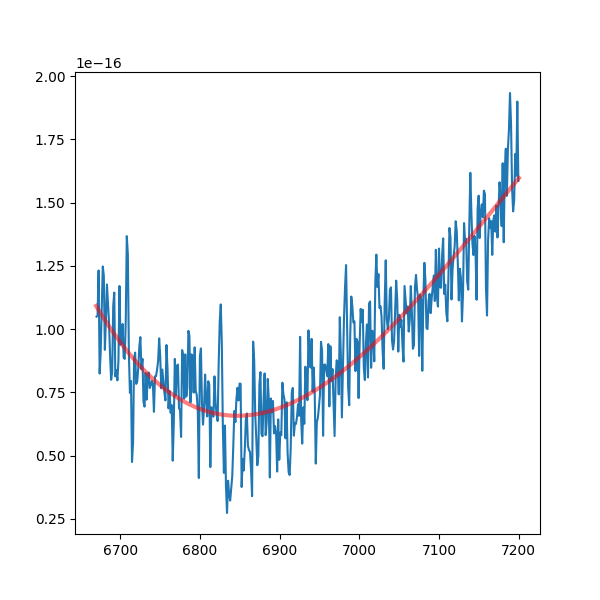

1.4661759974169466e-17
parameter #6 will be fixed
[{}, {}, {}, {}, {}, {}, {'fixed': True}, {}, {}, {}]
parameter #7 will be fixed
[{}, {}, {}, {}, {}, {}, {'fixed': True}, {'fixed': True}, {}, {}]
parameter #8 will be fixed
[{}, {}, {}, {}, {}, {}, {'fixed': True}, {'fixed': True}, {'fixed': True}, {}]
[{}, {}, {}, {}, {}, {}, {'fixed': True}, {'fixed': True}, {'fixed': True}, {'fixed': True}]
('Params:        ', [0.5822679533287293, 6281.349438499972, 43.20855508351624, 0.4742504062469598, 6491.563052314024, 111.90355029272784, 0.25, 6150.0, 50.0, 0.1])
('Errors from covariance matrix         : ', array([0.00617216, 0.5245776 , 0.65059489, 0.00305044, 1.69597417,
       1.60532832, 0.        , 0.        , 0.        , 0.        ]))
('Uncertainties assuming reduced Chi^2=1: ', array([0.01166288, 0.99123854, 1.22936003, 0.0057641 , 3.20470215,
       3.03341833, 0.        , 0.        , 0.        , 0.        ]))
('Chi^2 min:     ', 1942.387068062612)


<IPython.core.display.Javascript object>


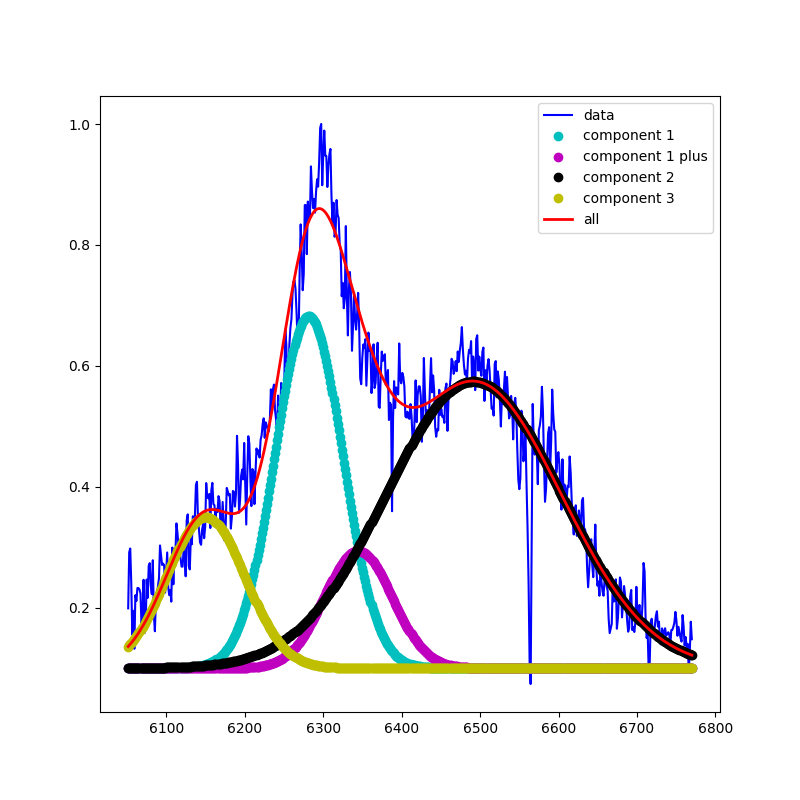

In [15]:
specname = 'binospec0131'
specdata = specs_22jli[specname]['spec_photcal']
xs = specdata[:,0]/(1+z)
ys = specdata[:,1]

mask = (xs>6670)*(xs<7200)
xfit = xs[mask]
yfit = ys[mask]

fitobj = polyfit(xfit, yfit, np.ones_like(xfit)*np.mean(yfit)*0.1, 3)

xmodel = np.linspace( 6670, 7200, 200 )
ymodel = poly3(fitobj.params, xmodel)
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(xfit, yfit)
ax.plot(xmodel, ymodel, 'r', alpha=0.5, lw=3)
yerr = np.std(yfit-  poly3(fitobj.params, xfit))
#print(yerr)


mask = (xs>6050)*(xs<6770)
xfit = xs[mask]
yfit = ys[mask]
normfac  = 1./np.max(yfit)
yfit = yfit*normfac
yerrfit = np.ones_like(xfit)*yerr*normfac

params0 = [0.6, 6300, 40, 0.3, 6520, 40, 0.25, 6150, 50, 0.1]

fitobj_binospec0131 = spec_OI6300_fitting(xfit, yfit, yerrfit, params0, display=True, fix_par_inds=[6,7,8], baselinefixed=True)

<IPython.core.display.Javascript object>


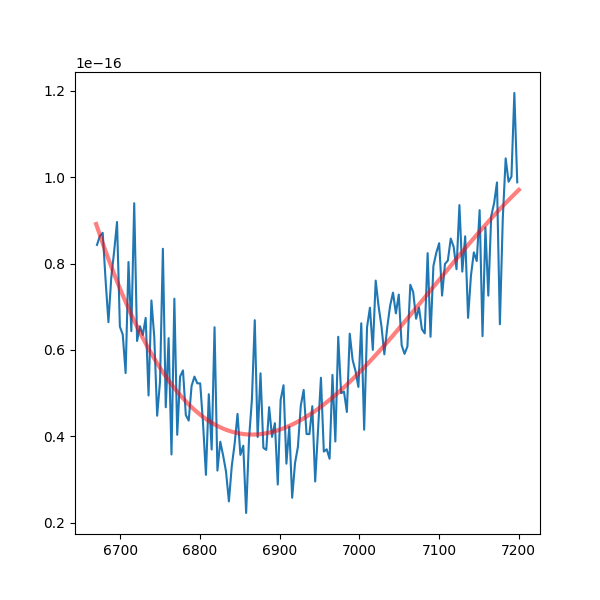

parameter #6 will be fixed
[{}, {}, {}, {}, {}, {}, {'fixed': True}, {}, {}, {}]
parameter #7 will be fixed
[{}, {}, {}, {}, {}, {}, {'fixed': True}, {'fixed': True}, {}, {}]
parameter #8 will be fixed
[{}, {}, {}, {}, {}, {}, {'fixed': True}, {'fixed': True}, {'fixed': True}, {}]
[{}, {}, {}, {}, {}, {}, {'fixed': True}, {'fixed': True}, {'fixed': True}, {'fixed': True}]
('Params:        ', [0.6306489279715742, 6289.835215979697, 48.35522480468062, 0.3883731918988399, 6515.258706763363, 104.47526067540599, 0.2, 6150.0, 50.0, 0.1])
('Errors from covariance matrix         : ', array([0.00687751, 0.7350528 , 0.78555061, 0.00431164, 2.35978686,
       2.36455922, 0.        , 0.        , 0.        , 0.        ]))
('Uncertainties assuming reduced Chi^2=1: ', array([0.01369721, 1.46392781, 1.56449902, 0.00858704, 4.69974075,
       4.70924537, 0.        , 0.        , 0.        , 0.        ]))
('Chi^2 min:     ', 777.4246720052223)


<IPython.core.display.Javascript object>


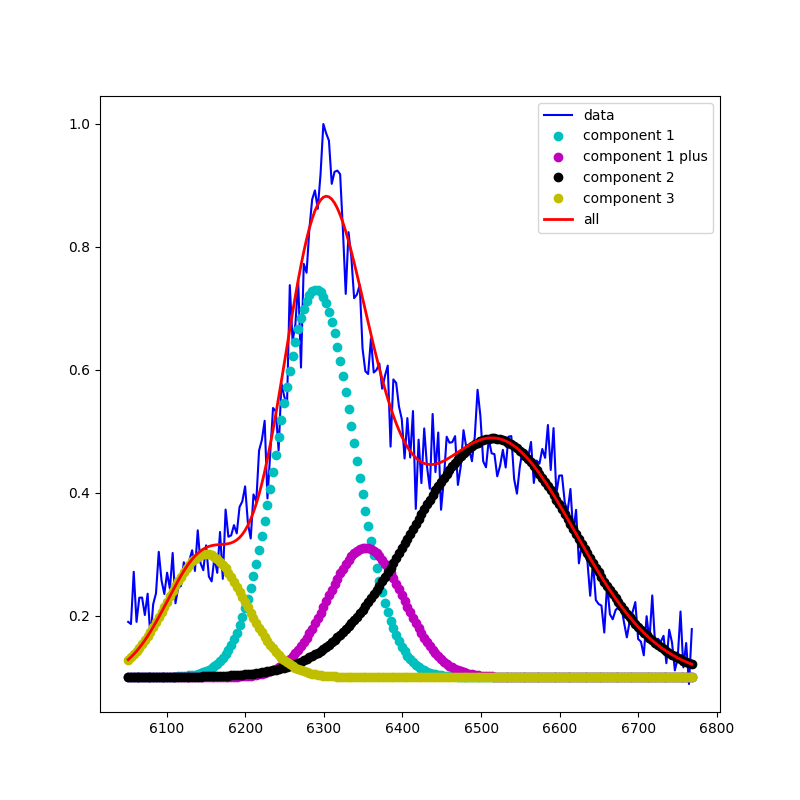

In [16]:
specname = 'not0203'
specdata = specs_22jli[specname]['spec_photcal']
xs = specdata[:,0]/(1+z)
ys = specdata[:,1]


mask = (xs>6670)*(xs<7200)
xfit = xs[mask]
yfit = ys[mask]

fitobj = polyfit(xfit, yfit, np.ones_like(xfit)*np.mean(yfit)*0.1, 3)

xmodel = np.linspace( 6670, 7200, 200 )
ymodel = poly3(fitobj.params, xmodel)
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(xfit, yfit)
ax.plot(xmodel, ymodel, 'r', alpha=0.5, lw=3)
yerr = np.std(yfit-  poly3(fitobj.params, xfit))
#print(yerr)

mask = (xs>6050)*(xs<6770)
xfit = xs[mask]
yfit = ys[mask]
normfac  = 1./np.max(yfit)
yfit = yfit*normfac
yerrfit = np.ones_like(xfit)*yerr*normfac

params0 = [0.6, 6300, 40, 0.3, 6520, 40, 0.2, 6150, 50, 0.1]

fitobj_not0203 = spec_OI6300_fitting(xfit, yfit, yerrfit, params0, display=True, fix_par_inds=[6,7,8], baselinefixed=True)

<IPython.core.display.Javascript object>


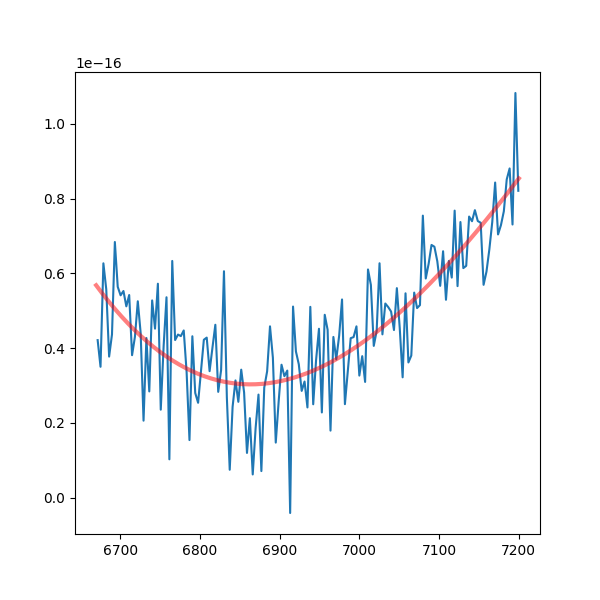

parameter #6 will be fixed
[{}, {}, {}, {}, {}, {}, {'fixed': True}, {}, {}, {}]
parameter #7 will be fixed
[{}, {}, {}, {}, {}, {}, {'fixed': True}, {'fixed': True}, {}, {}]
parameter #8 will be fixed
[{}, {}, {}, {}, {}, {}, {'fixed': True}, {'fixed': True}, {'fixed': True}, {}]
[{}, {}, {}, {}, {}, {}, {'fixed': True}, {'fixed': True}, {'fixed': True}, {'fixed': True}]
('Params:        ', [0.6744611023626358, 6293.477579452273, 49.31683425160695, 0.34391739173975894, 6525.982938292525, 98.29491638013555, 0.15, 6150.0, 50.0, 0.1])
('Errors from covariance matrix         : ', array([0.00930793, 1.00343001, 1.05405872, 0.00661209, 3.36478649,
       3.50774015, 0.        , 0.        , 0.        , 0.        ]))
('Uncertainties assuming reduced Chi^2=1: ', array([0.01535555, 1.65538551, 1.73890905, 0.01090814, 5.55097886,
       5.78681338, 0.        , 0.        , 0.        , 0.        ]))
('Chi^2 min:     ', 533.4333903798987)


<IPython.core.display.Javascript object>


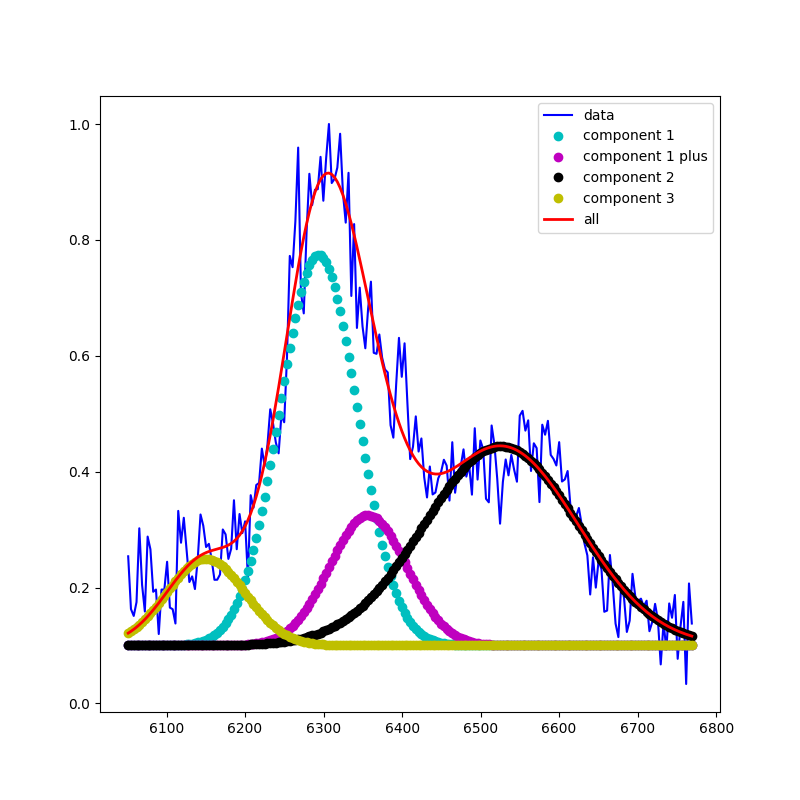

In [17]:
#specname = 'binospec0131'
#specname = 'not0203'
specname = 'not0208'
specdata = specs_22jli[specname]['spec_photcal']
xs = specdata[:,0]/(1+z)
ys = specdata[:,1]

mask = (xs>6670)*(xs<7200)
xfit = xs[mask]
yfit = ys[mask]

fitobj = polyfit(xfit, yfit, np.ones_like(xfit)*np.mean(yfit)*0.1, 3)

xmodel = np.linspace( 6670, 7200, 200 )
ymodel = poly3(fitobj.params, xmodel)
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(xfit, yfit)
ax.plot(xmodel, ymodel, 'r', alpha=0.5, lw=3)
yerr = np.std(yfit-  poly3(fitobj.params, xfit))
#print(yerr)


mask = (xs>6050)*(xs<6770)
xfit = xs[mask]
yfit = ys[mask]
normfac  = 1./np.max(yfit)
yfit = yfit*normfac
yerrfit = np.ones_like(xfit)*yerr*normfac

params0 = [0.6, 6300, 40, 0.3, 6520, 40, 0.15, 6150, 50, 0.1]

fitobj_not0208 = spec_OI6300_fitting(xfit, yfit, yerrfit, params0, display=True, fix_par_inds=[6,7,8], baselinefixed=True)

<IPython.core.display.Javascript object>


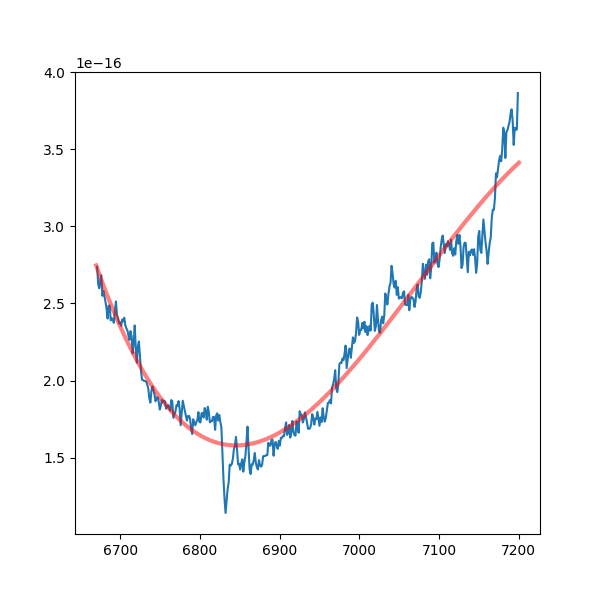

parameter #1 will be fixed
[{}, {'fixed': True}, {}, {}, {}, {}, {}, {}, {}, {}]
parameter #2 will be fixed
[{}, {'fixed': True}, {'fixed': True}, {}, {}, {}, {}, {}, {}, {}]
parameter #3 will be fixed
[{}, {'fixed': True}, {'fixed': True}, {'fixed': True}, {}, {}, {}, {}, {}, {}]
parameter #4 will be fixed
[{}, {'fixed': True}, {'fixed': True}, {'fixed': True}, {'fixed': True}, {}, {}, {}, {}, {}]
parameter #5 will be fixed
[{}, {'fixed': True}, {'fixed': True}, {'fixed': True}, {'fixed': True}, {'fixed': True}, {}, {}, {}, {}]
parameter #6 will be fixed
[{}, {'fixed': True}, {'fixed': True}, {'fixed': True}, {'fixed': True}, {'fixed': True}, {'fixed': True}, {}, {}, {}]
parameter #7 will be fixed
[{}, {'fixed': True}, {'fixed': True}, {'fixed': True}, {'fixed': True}, {'fixed': True}, {'fixed': True}, {'fixed': True}, {}, {}]
parameter #8 will be fixed
[{}, {'fixed': True}, {'fixed': True}, {'fixed': True}, {'fixed': True}, {'fixed': True}, {'fixed': True}, {'fixed': True}, {'fixed':

<IPython.core.display.Javascript object>


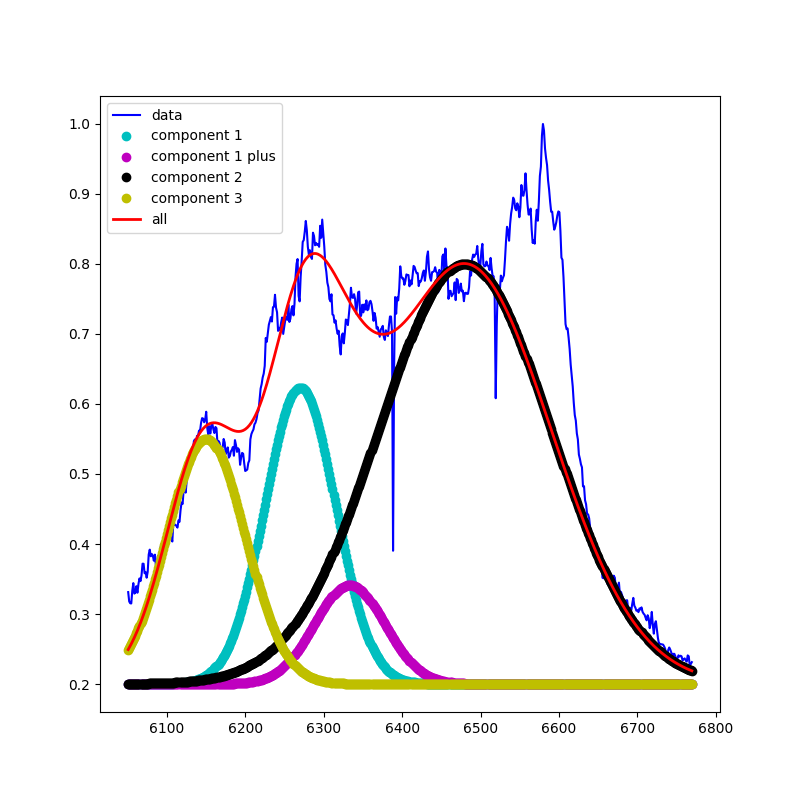

([0.42340303683065206,
  6270.0,
  45.0,
  0.6,
  6480.0,
  110.0,
  0.35,
  6150.0,
  50.0,
  0.2],
 array([0.01001257, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]))

In [18]:
specname = 'binospec1227'
specdata = specs_22jli[specname]['spec_photcal']
xs = specdata[:,0]/(1+z)
ys = specdata[:,1]


mask = (xs>6670)*(xs<7200)
xfit = xs[mask]
yfit = ys[mask]

fitobj = polyfit(xfit, yfit, np.ones_like(xfit)*np.mean(yfit)*0.1, 3)

xmodel = np.linspace( 6670, 7200, 200 )
ymodel = poly3(fitobj.params, xmodel)
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(xfit, yfit)
ax.plot(xmodel, ymodel, 'r', alpha=0.5, lw=3)
yerr = np.std(yfit-  poly3(fitobj.params, xfit))
#print(yerr)

mask = (xs>6050)*(xs<6770)
xfit = xs[mask]
yfit = ys[mask]
normfac  = 1./np.max(yfit)
yfit = yfit*normfac
yerrfit = np.ones_like(xfit)*yerr*normfac

params0 = [0.2, 6270, 45, 0.6, 6480, 110, 0.35, 6150, 50, 0.2]

spec_OI6300_fitting(xfit, yfit, yerrfit, params0, display=True, fix_par_inds=[1,2,3,4,5,6,7,8], baselinefixed=True)

#### plot 

6574.25


<IPython.core.display.Javascript object>


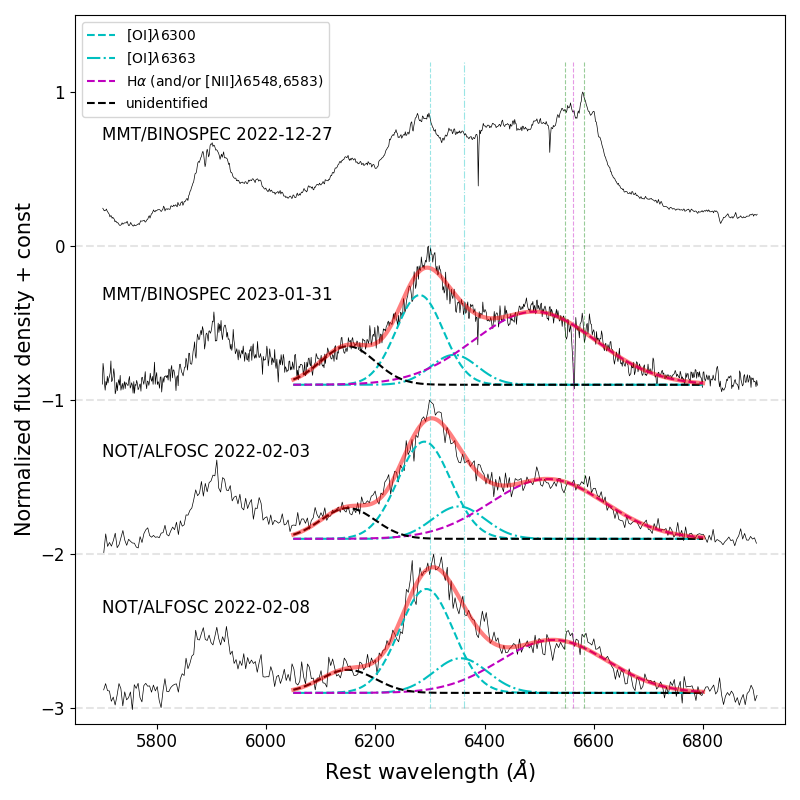

the first epoch: OI -888.1219761918017; Halpha -3256.3973160530168; NII -3773.2188927699253
line width (sigma): OI 43.20855508351624; Ha or NII: 111.90355029272784
line width errors: OI 1.2293600272168874; Ha or NII: 3.0334183287499243
the second epoch: OI -484.03733430015046; Halpha -2173.2169151872877; NII -2691.92500604496
line width (sigma): OI 48.35522480468062; Ha or NII: 104.47526067540599
line width errors: OI 1.5644990198225301; Ha or NII: 4.709245372888688
the third epoch: OI -310.59145465366913; Halpha -1682.988741427809; NII -2202.5506350142405
line width (sigma): OI 49.31683425160695; Ha or NII: 98.29491638013555
line width errors: OI 1.7389090517978236; Ha or NII: 5.7868133772527


In [19]:
NII_wrest = (6583*3+6548)/4 #the rest wavelength of [NII]6548, 6583 
print(NII_wrest)

fig, ax = plt.subplots(figsize=(8,8))


#---------------------- for reference 

specname = 'binospec1227'
specdata = specs_22jli[specname]['spec_photcal']
xs = specdata[:,0]/(1+z)
ys = specdata[:,1]

mask = (xs>5700)*(xs<6900)
xplot = xs[mask]
yplot = ys[mask]
normfac  = 1./np.max(yplot)
yplot = yplot*normfac

offset =0
ax.plot(xplot, yplot, lw=0.5, color='k')
ax.text(5700, np.mean(yplot+offset)+0.2, 'MMT/BINOSPEC 2022-12-27', fontsize=12)



specnames = []
w1_list = []
w1err_list =[]
w2_list = []
w2err_list = []
sigma1_list = []
sigma1err_list =[]
sigma2_list = []
sigma2err_list = []


#----------------------------------------------------------
specname = 'binospec0131'
specdata = specs_22jli[specname]['spec_photcal']
xs = specdata[:,0]/(1+z)
ys = specdata[:,1]

mask = (xs>5700)*(xs<6900)
xplot = xs[mask]
yplot = ys[mask]
normfac  = 1./np.max(yplot)
yplot = yplot*normfac

offset = -1
ax.plot(xplot, yplot+offset, lw=0.5, color='k')




pfits = fitobj_binospec0131[0]
stderrs = fitobj_binospec0131[1]
x = np.linspace(6050, 6800, 1000)
flux_fit = OI_Halpha_model(pfits, x)

p1 = [pfits[0], pfits[1], pfits[2], pfits[-1]]
p1_plus = [pfits[0]/3.0, pfits[1]+63, pfits[2], pfits[-1]]
p2 = [pfits[3], pfits[4], pfits[5], pfits[-1]]

v1_OI = (p1[1]-6300)/6300*300000
v1_Ha = (p2[1]-6562.8)/6562.8*300000
v1_NII  = (p2[1]-NII_wrest)/NII_wrest*300000
print('the first epoch: OI %s; Halpha %s; NII %s'%(v1_OI, v1_Ha, v1_NII))
print('line width (sigma): OI %s; Ha or NII: %s'%(p1[2], p2[2]))
print('line width errors: OI %s; Ha or NII: %s'%(stderrs[2], stderrs[5]))

specnames.append(specname)
w1_list.append(np.round(p1[1],1))
w1err_list.append(np.round(stderrs[1]))
w2_list.append(np.round(p2[1]))
w2err_list.append(np.round(stderrs[4]))
sigma1_list.append(np.round(p1[2]))
sigma1err_list.append(np.round(stderrs[2]))
sigma2_list.append(np.round(p2[2]))
sigma2err_list.append(np.round(stderrs[5]))


p3 = [pfits[6], pfits[7], pfits[8], pfits[-1]]
comp1 = single_gaussian(p1, x)
comp1_plus = single_gaussian(p1_plus, x)
comp2 = single_gaussian(p2, x)
comp3 = single_gaussian(p3, x)
ax.plot(x, comp1+offset, 'c--', label=r'[OI]$\lambda$6300')
ax.plot(x, comp1_plus+offset, 'c-.', label=r'[OI]$\lambda$6363')
ax.plot(x, comp2+offset, 'm--', label=r'H$\alpha$ (and/or [NII]$\lambda$6548,6583)')
ax.plot(x, comp3+offset, 'k--', label='unidentified')

ax.legend(loc=2)
ax.plot(x, flux_fit+offset, 'r', linewidth=3, alpha=0.5, label='total')
ax.text(5700, np.mean(yplot+offset)+0.3, 'MMT/BINOSPEC 2023-01-31', fontsize=12)



#----------------------------------------------------------
specname = 'not0203'
specdata = specs_22jli[specname]['spec_photcal']
xs = specdata[:,0]/(1+z)
ys = specdata[:,1]

mask = (xs>5700)*(xs<6900)
xplot = xs[mask]
yplot = ys[mask]
normfac  = 1./np.max(yplot)
yplot = yplot*normfac
offset = -2
ax.plot(xplot, yplot+offset, lw=0.5, color='k')
ax.text(5700, np.mean(yplot+offset)+0.3, 'NOT/ALFOSC 2022-02-03', fontsize=12)

pfits = fitobj_not0203[0]
stderrs = fitobj_not0203[1]
x = np.linspace(6050, 6800, 1000)
flux_fit = OI_Halpha_model(pfits, x)

p1 = [pfits[0], pfits[1], pfits[2], pfits[-1]]
p1_plus = [pfits[0]/3.0, pfits[1]+63, pfits[2], pfits[-1]]
p2 = [pfits[3], pfits[4], pfits[5], pfits[-1]]

v2_OI = (p1[1]-6300)/6300*300000
v2_Ha = (p2[1]-6562.8)/6562.8*300000
v2_NII  = (p2[1]-NII_wrest)/NII_wrest*300000
print('the second epoch: OI %s; Halpha %s; NII %s'%(v2_OI, v2_Ha, v2_NII))
print('line width (sigma): OI %s; Ha or NII: %s'%(p1[2], p2[2]))
print('line width errors: OI %s; Ha or NII: %s'%(stderrs[2], stderrs[5]))

specnames.append(specname)
w1_list.append(np.round(p1[1],1))
w1err_list.append(np.round(stderrs[1]))
w2_list.append(np.round(p2[1]))
w2err_list.append(np.round(stderrs[4]))
sigma1_list.append(np.round(p1[2]))
sigma1err_list.append(np.round(stderrs[2]))
sigma2_list.append(np.round(p2[2]))
sigma2err_list.append(np.round(stderrs[5]))


p3 = [pfits[6], pfits[7], pfits[8], pfits[-1]]
comp1 = single_gaussian(p1, x)
comp1_plus = single_gaussian(p1_plus, x)
comp2 = single_gaussian(p2, x)
comp3 = single_gaussian(p3, x)
ax.plot(x, comp1+offset, 'c--', label=r'[OI]$\lambda$6300')
ax.plot(x, comp1_plus+offset, 'c-.', label=r'[OI]$\lambda$6363')
ax.plot(x, comp2+offset, 'm--', label=r'H$\alpha$')
ax.plot(x, comp3+offset, 'k--', label='unidentified')

ax.plot(x, flux_fit+offset, 'r', linewidth=3, alpha=0.5, label='total')




#----------------------------------------------------------
specname = 'not0208'
specdata = specs_22jli[specname]['spec_photcal']
xs = specdata[:,0]/(1+z)
ys = specdata[:,1]

mask = (xs>5700)*(xs<6900)
xplot = xs[mask]
yplot = ys[mask]
normfac  = 1./np.max(yplot)
yplot = yplot*normfac
offset = -3
ax.plot(xplot, yplot+offset, lw=0.5, color='k')
ax.text(5700, np.mean(yplot+offset)+0.3, 'NOT/ALFOSC 2022-02-08', fontsize=12)


pfits = fitobj_not0208[0]
stderrs = fitobj_not0208[1]
x = np.linspace(6050, 6800, 1000)
flux_fit = OI_Halpha_model(pfits, x)

p1 = [pfits[0], pfits[1], pfits[2], pfits[-1]]
p1_plus = [pfits[0]/3.0, pfits[1]+63, pfits[2], pfits[-1]]
p2 = [pfits[3], pfits[4], pfits[5], pfits[-1]]

v3_OI = (p1[1]-6300)/6300*300000
v3_Ha = (p2[1]-6562.8)/6562.8*300000
v3_NII  = (p2[1]-NII_wrest)/NII_wrest*300000
print('the third epoch: OI %s; Halpha %s; NII %s'%(v3_OI, v3_Ha, v3_NII))
print('line width (sigma): OI %s; Ha or NII: %s'%(p1[2], p2[2]))
print('line width errors: OI %s; Ha or NII: %s'%(stderrs[2], stderrs[5]))

specnames.append(specname)
w1_list.append(np.round(p1[1],1))
w1err_list.append(np.round(stderrs[1]))
w2_list.append(np.round(p2[1]))
w2err_list.append(np.round(stderrs[4]))
sigma1_list.append(np.round(p1[2]))
sigma1err_list.append(np.round(stderrs[2]))
sigma2_list.append(np.round(p2[2]))
sigma2err_list.append(np.round(stderrs[5]))


p3 = [pfits[6], pfits[7], pfits[8], pfits[-1]]
comp1 = single_gaussian(p1, x)
comp1_plus = single_gaussian(p1_plus, x)
comp2 = single_gaussian(p2, x)
comp3 = single_gaussian(p3, x)
ax.plot(x, comp1+offset, 'c--', label=r'[OI]$\lambda$6300')
ax.plot(x, comp1_plus+offset, 'c-.', label=r'[OI]$\lambda$6363')
ax.plot(x, comp2+offset, 'm--', label=r'H$\alpha$ (and/or [NII]$\lambda$6548,6583)')
ax.plot(x, comp3+offset, 'k--', label='unidentified')

ax.plot(x, flux_fit+offset, 'r', linewidth=3, alpha=0.5, label='total')




ax.set_xlabel(r'Rest wavelength ($\AA$)', fontsize=15)

ax.set_ylabel('Normalized flux density + const', fontsize=15)

ax.xaxis.set_major_locator(MultipleLocator(200))
ax.yaxis.set_major_locator(MultipleLocator(1))

ax.tick_params(labelsize=12)
ax.set_xlim([5650, 6950])
ax.set_ylim([-3.1, 1.5])
ax.hlines([-3, -2, -1, 0], xmin=5650, xmax=6950, linestyles='dashed', alpha=0.1, color='k')

ax.vlines([6300], ymin=-3, ymax=1.2, linestyles='dashed', color='c', alpha=0.4, lw=0.8)
ax.vlines([6363], ymin=-3, ymax=1.2, linestyles='dashdot',color='c', alpha=0.4, lw=0.8)

ax.vlines([6562.8], ymin=-3, ymax=1.2, linestyles='dashed',color='m', alpha=0.4, lw=0.8)
ax.vlines([6548, 6583], ymin=-3, ymax=1.2, linestyles='dashed',color='g', alpha=0.4, lw=0.8)

plt.tight_layout()



fitret = Table([specnames,w1_list,w1err_list,w2_list,w2err_list,sigma1_list,sigma1err_list,sigma2_list,sigma2err_list], names=['specname', 'w1', 'w1_err', 'w2', 'w2_err', 'sigma1', 'sigma1_err', 'sigma2', 'sigma2_err'])
fitret.write('../plots/decomposition_result.tex', format='ascii.latex')

plt.savefig('../plots/OI_Halpha_decomp.pdf')

In [39]:
vfwhm = 47*2.35/6300*300000
print(vfwhm)
print(4*2.35/6300*300000)

vfwhm = 43*2.35/6300*300000
print(vfwhm)
print(1.7*2.35/6300*300000)

vfwhm = 49.3*2.35/6300*300000
print(vfwhm)
print(1.7*2.35/6300*300000)

5259.52380952381
447.6190476190476
5516.9047619047615
190.23809523809524


<IPython.core.display.Javascript object>


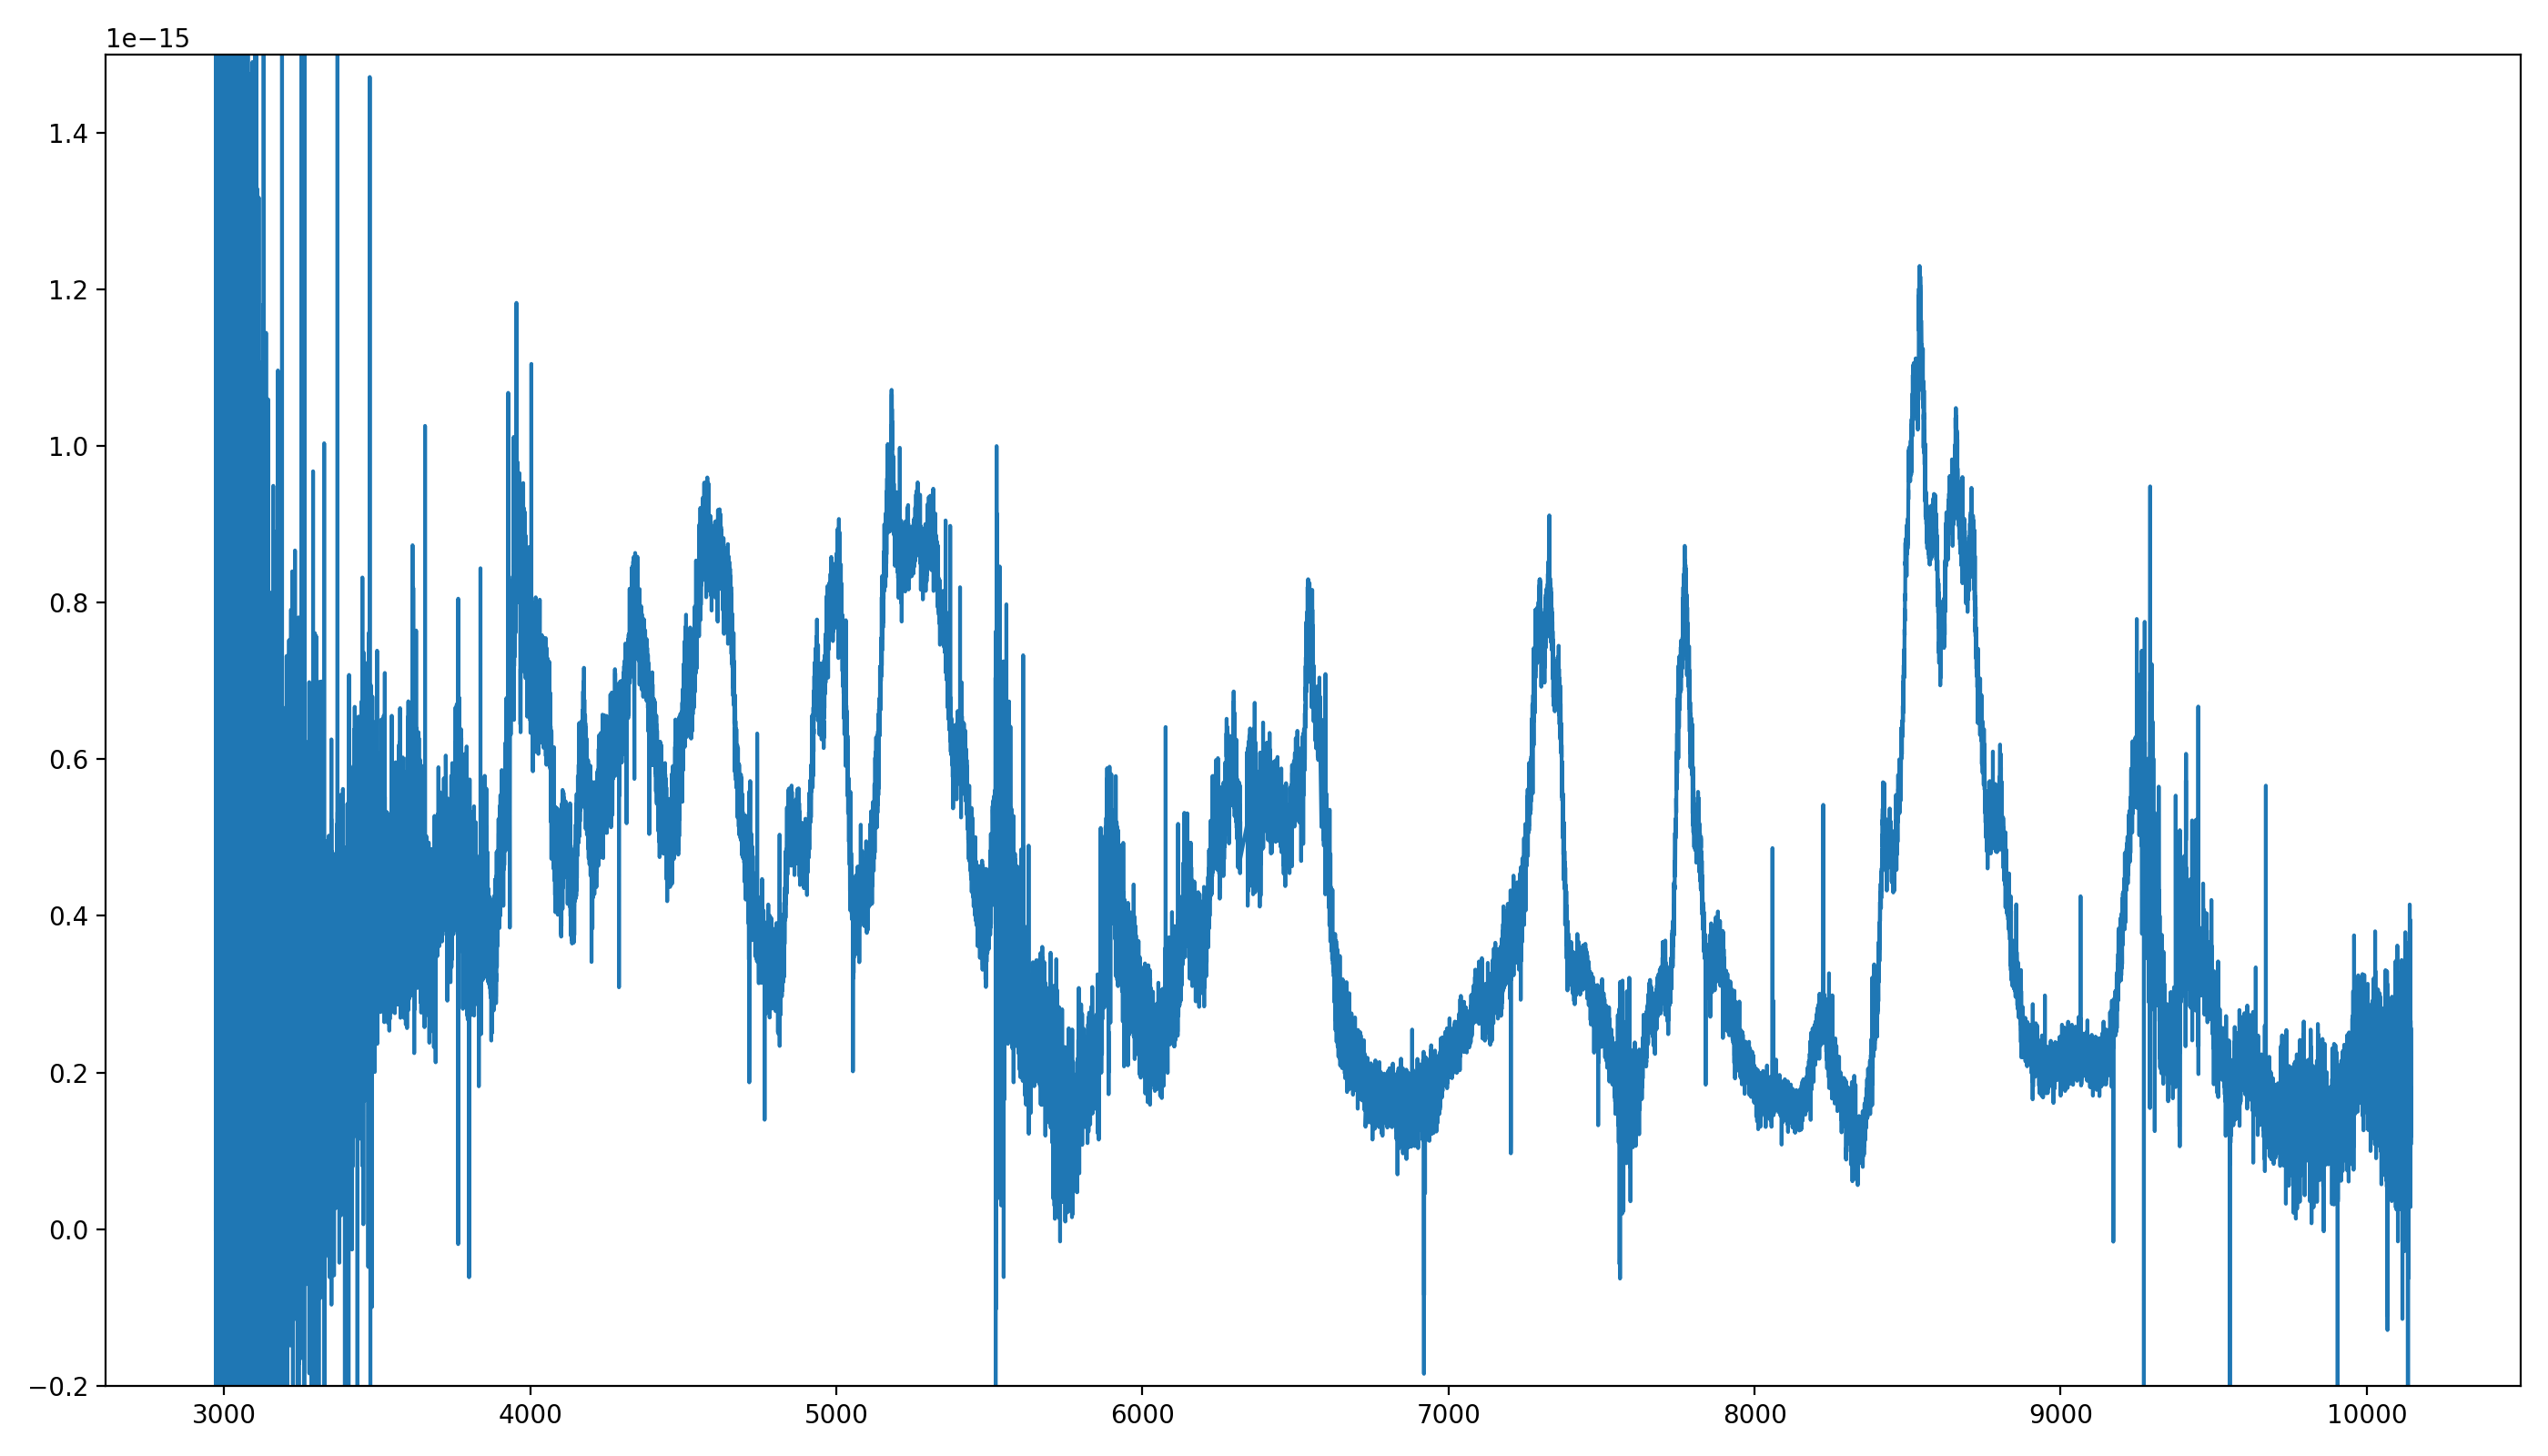

('Params:        ', [0.399836650253957, 9303.606242442189, 40.891135860565846, 0.22453844225581807])
('Errors from covariance matrix         : ', array([0.01262001, 0.76316389, 1.79151882, 0.01338842]))
('Uncertainties assuming reduced Chi^2=1: ', array([0.00829482, 0.50160881, 1.17752115, 0.00879988]))
('Chi^2 min:     ', 429.8508216663092)


<IPython.core.display.Javascript object>


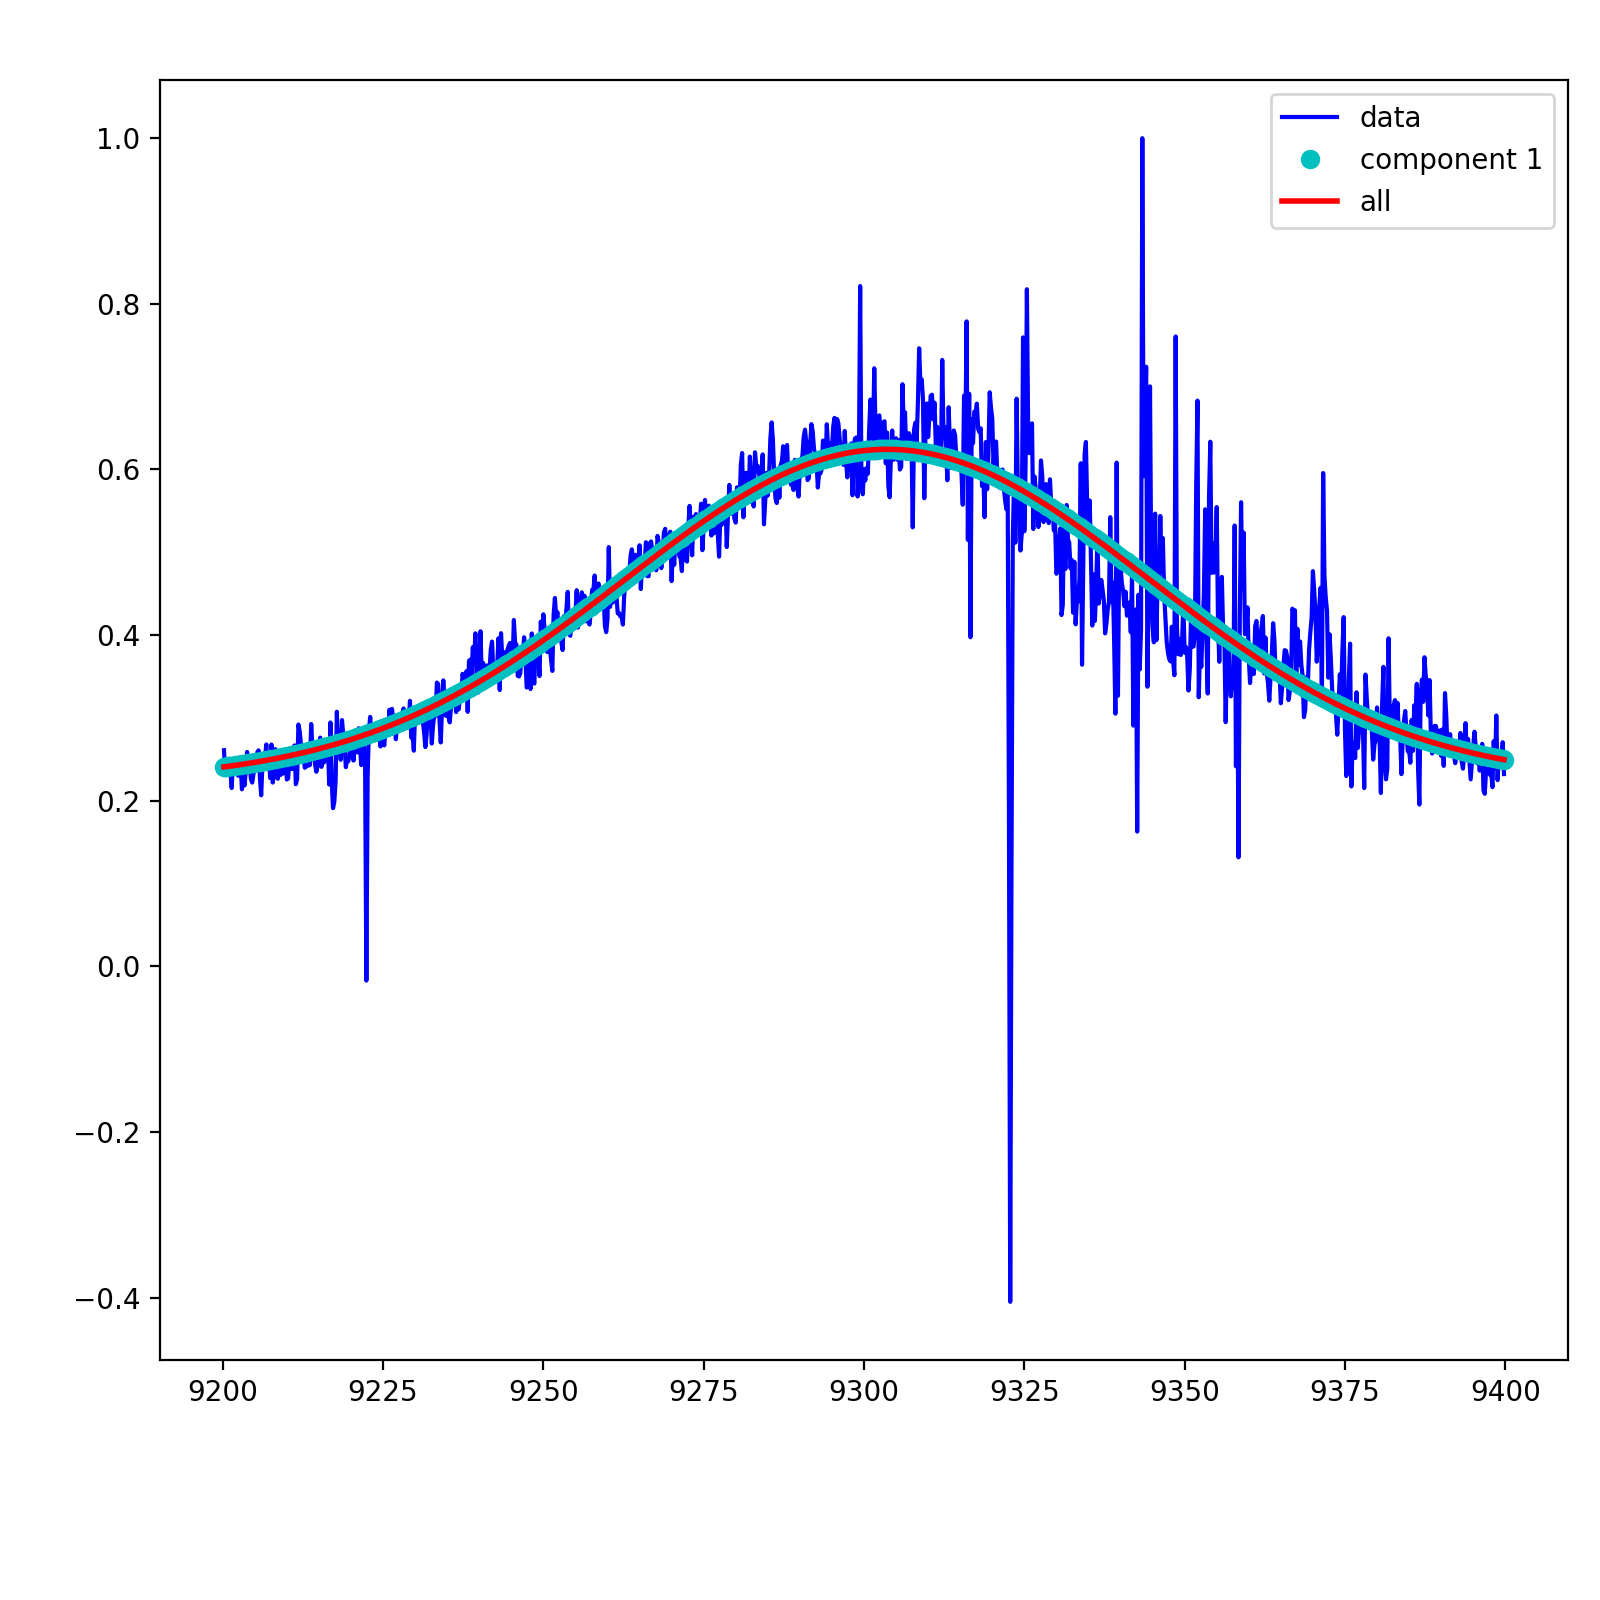

3044.3700744899065
('Params:        ', [0.525352666472401, 7817.2251199256425, 23.78901624183178, 0.3796586840792398])
('Errors from covariance matrix         : ', array([0.01000358, 0.44121315, 0.63074669, 0.0073253 ]))
('Uncertainties assuming reduced Chi^2=1: ', array([0.00576071, 0.25407911, 0.3632248 , 0.00421838]))
('Chi^2 min:     ', 263.6380946795355)


<IPython.core.display.Javascript object>


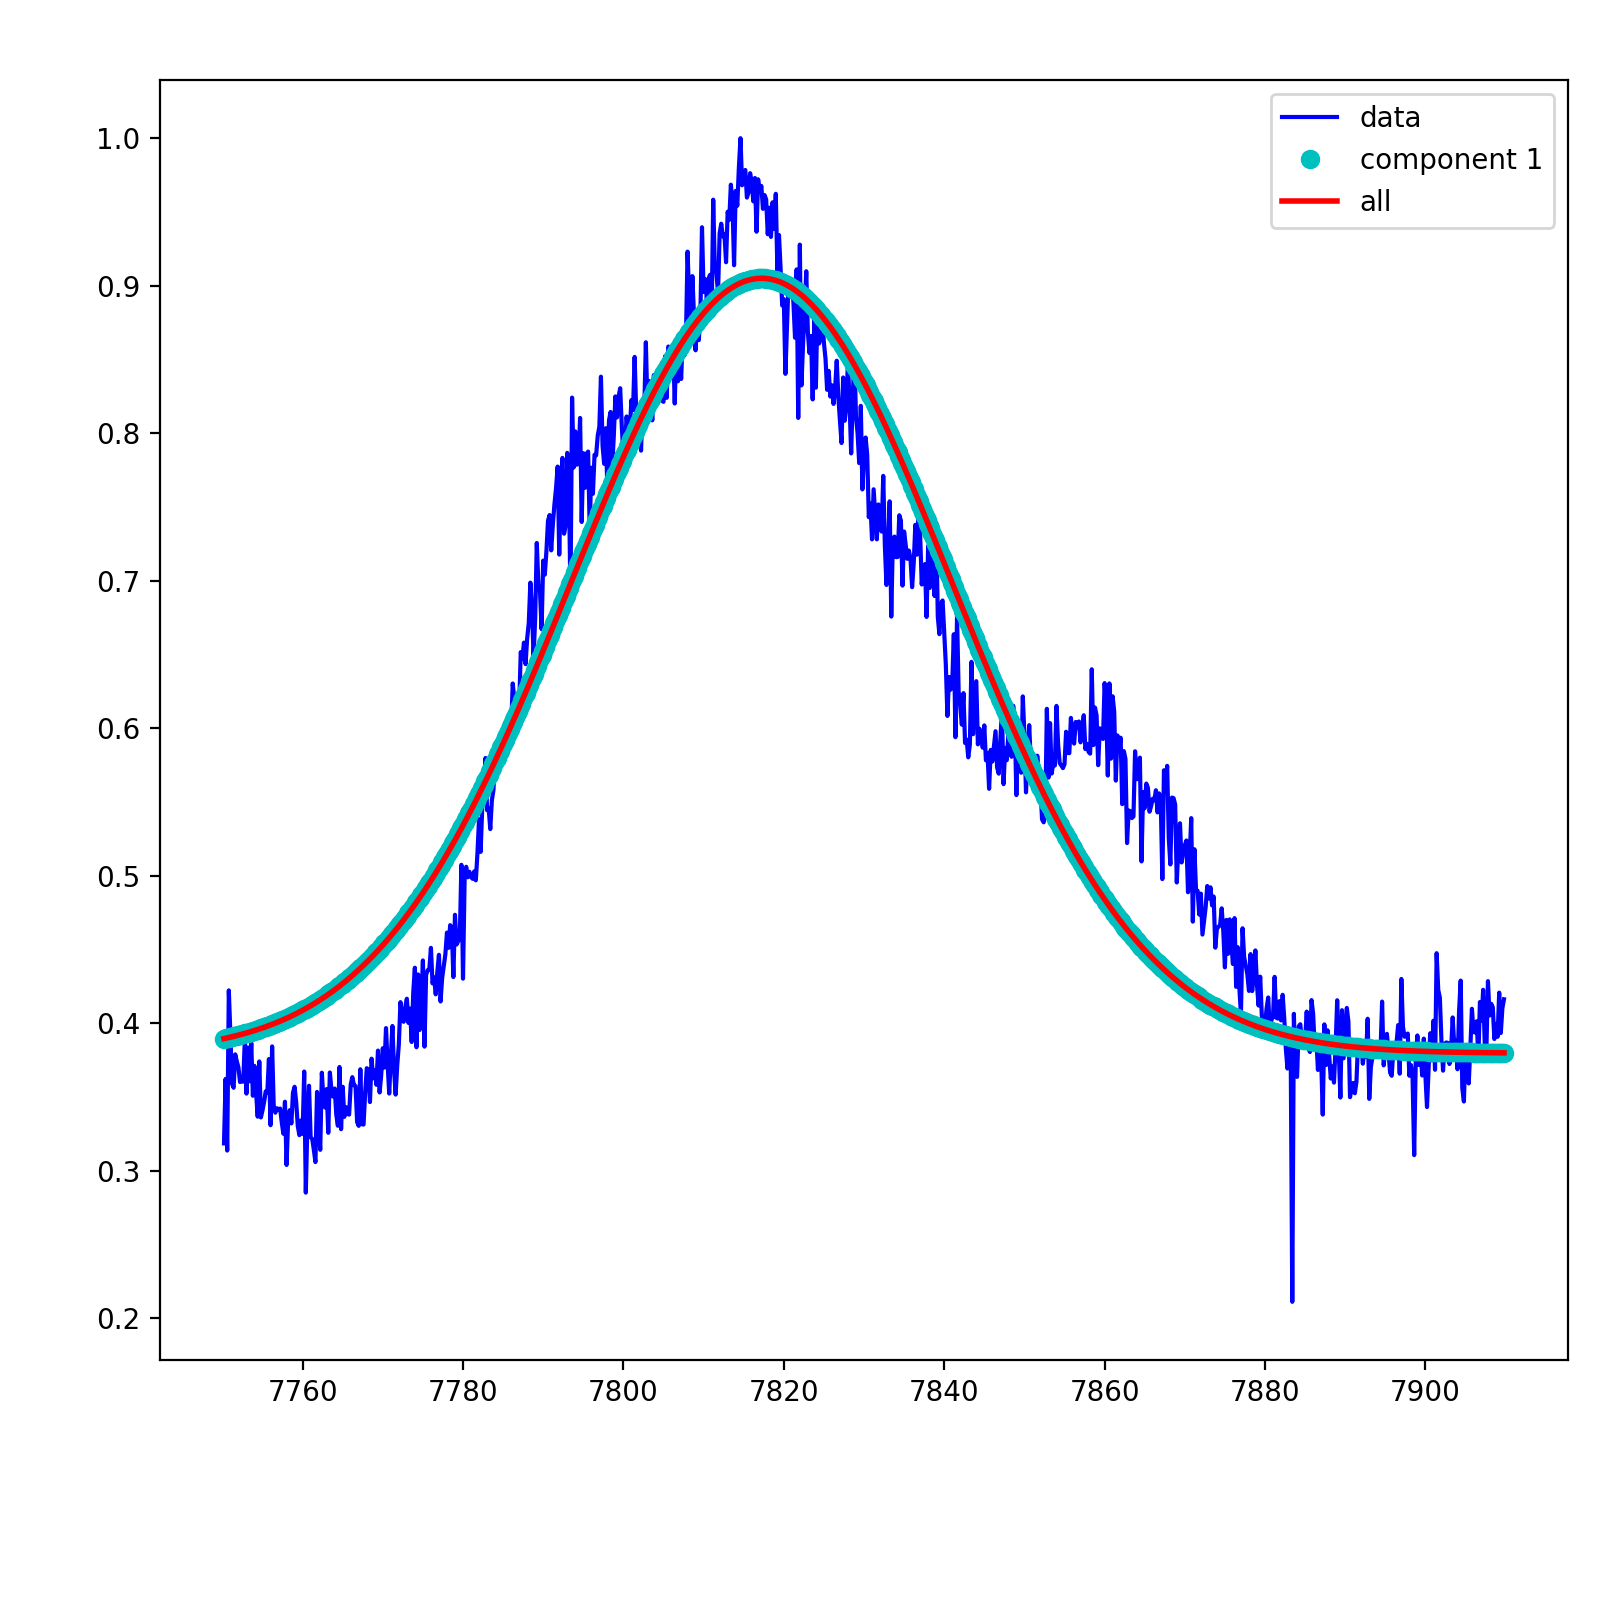

2158.3483406225882
32.64728582454335


In [60]:
specdata = specs_22jli['xsh0118']['spec']
fig,ax = plt.subplots(figsize=(14,8))
ax.plot(specdata[:,0]/(1+z_22jli), specdata[:,1])
ax.set_ylim([-2e-16, 1.5e-15])

plt.tight_layout()


xs = specdata[:,0]
ys = specdata[:,1]
mask = (xs>9200)*(xs<9400)
xfit = xs[mask]
yfit = ys[mask]
normfac  = 1./np.max(yfit)
yfit = yfit*normfac
yerr = 0.1
yerrfit = np.ones_like(xfit)*yerr

params0 = [10, 9300, 40, 0]
spec_1gaussian_fitting(xfit, yfit, yerrfit, params0, display=True, fix_par_inds=None, show_yerr=False, verbose=1)


vfwhm_OI9263_xsh0118 = 40*2.35/9263*300000
print(vfwhm_OI9263_xsh0118)


xs = specdata[:,0]
ys = specdata[:,1]
mask = (xs>7750)*(xs<7910)
xfit = xs[mask]
yfit = ys[mask]
normfac  = 1./np.max(yfit)
yfit = yfit*normfac
yerr = 0.1
yerrfit = np.ones_like(xfit)*yerr

params0 = [10, 7780, 40, 0]
spec_1gaussian_fitting(xfit, yfit, yerrfit, params0, display=True, fix_par_inds=None, show_yerr=False, verbose=1)


vfwhm_OI7774_xsh0118 = 23.8*2.35/7774*300000
print(vfwhm_OI7774_xsh0118)
print(0.36*2.35/7774*300000)

<IPython.core.display.Javascript object>


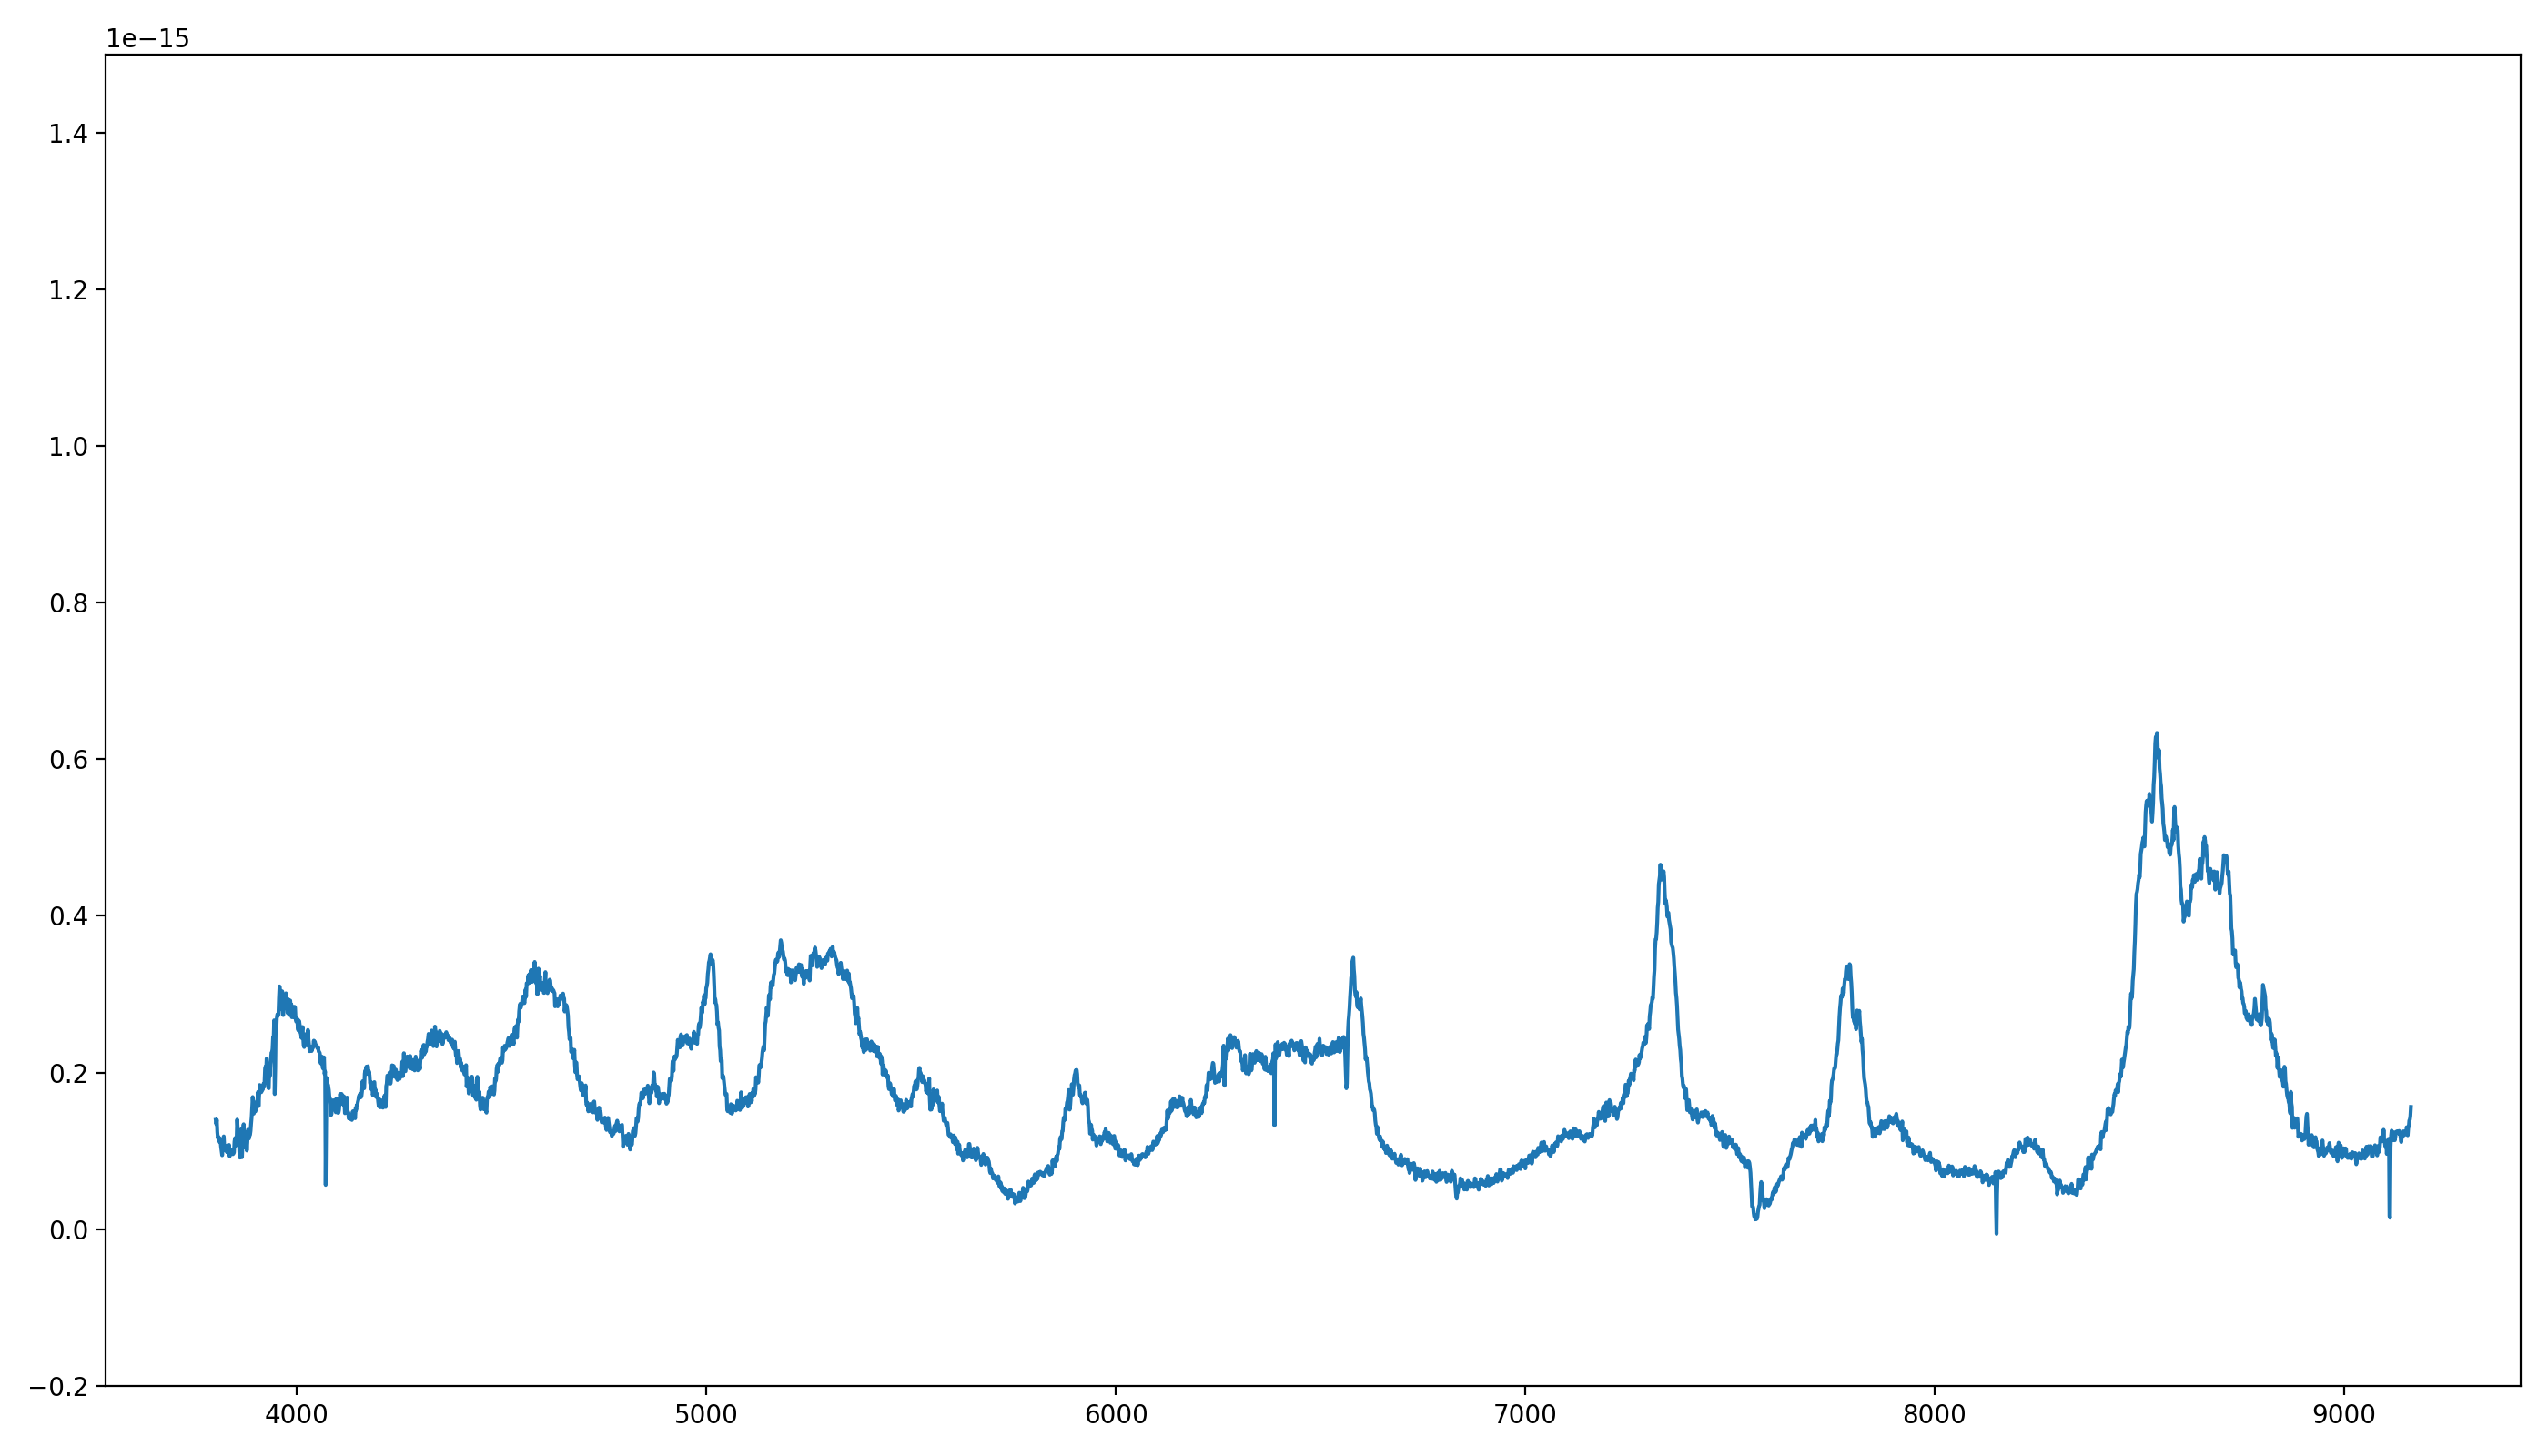

('Params:        ', [0.6079729344588947, 7832.724167292382, 26.258079190318984, 0.3534820343553065])
('Errors from covariance matrix         : ', array([0.02229243, 1.02721038, 1.26156468, 0.01202547]))
('Uncertainties assuming reduced Chi^2=1: ', array([0.00822002, 0.37876948, 0.46518436, 0.00443422]))
('Chi^2 min:     ', 23.250231513507067)


<IPython.core.display.Javascript object>


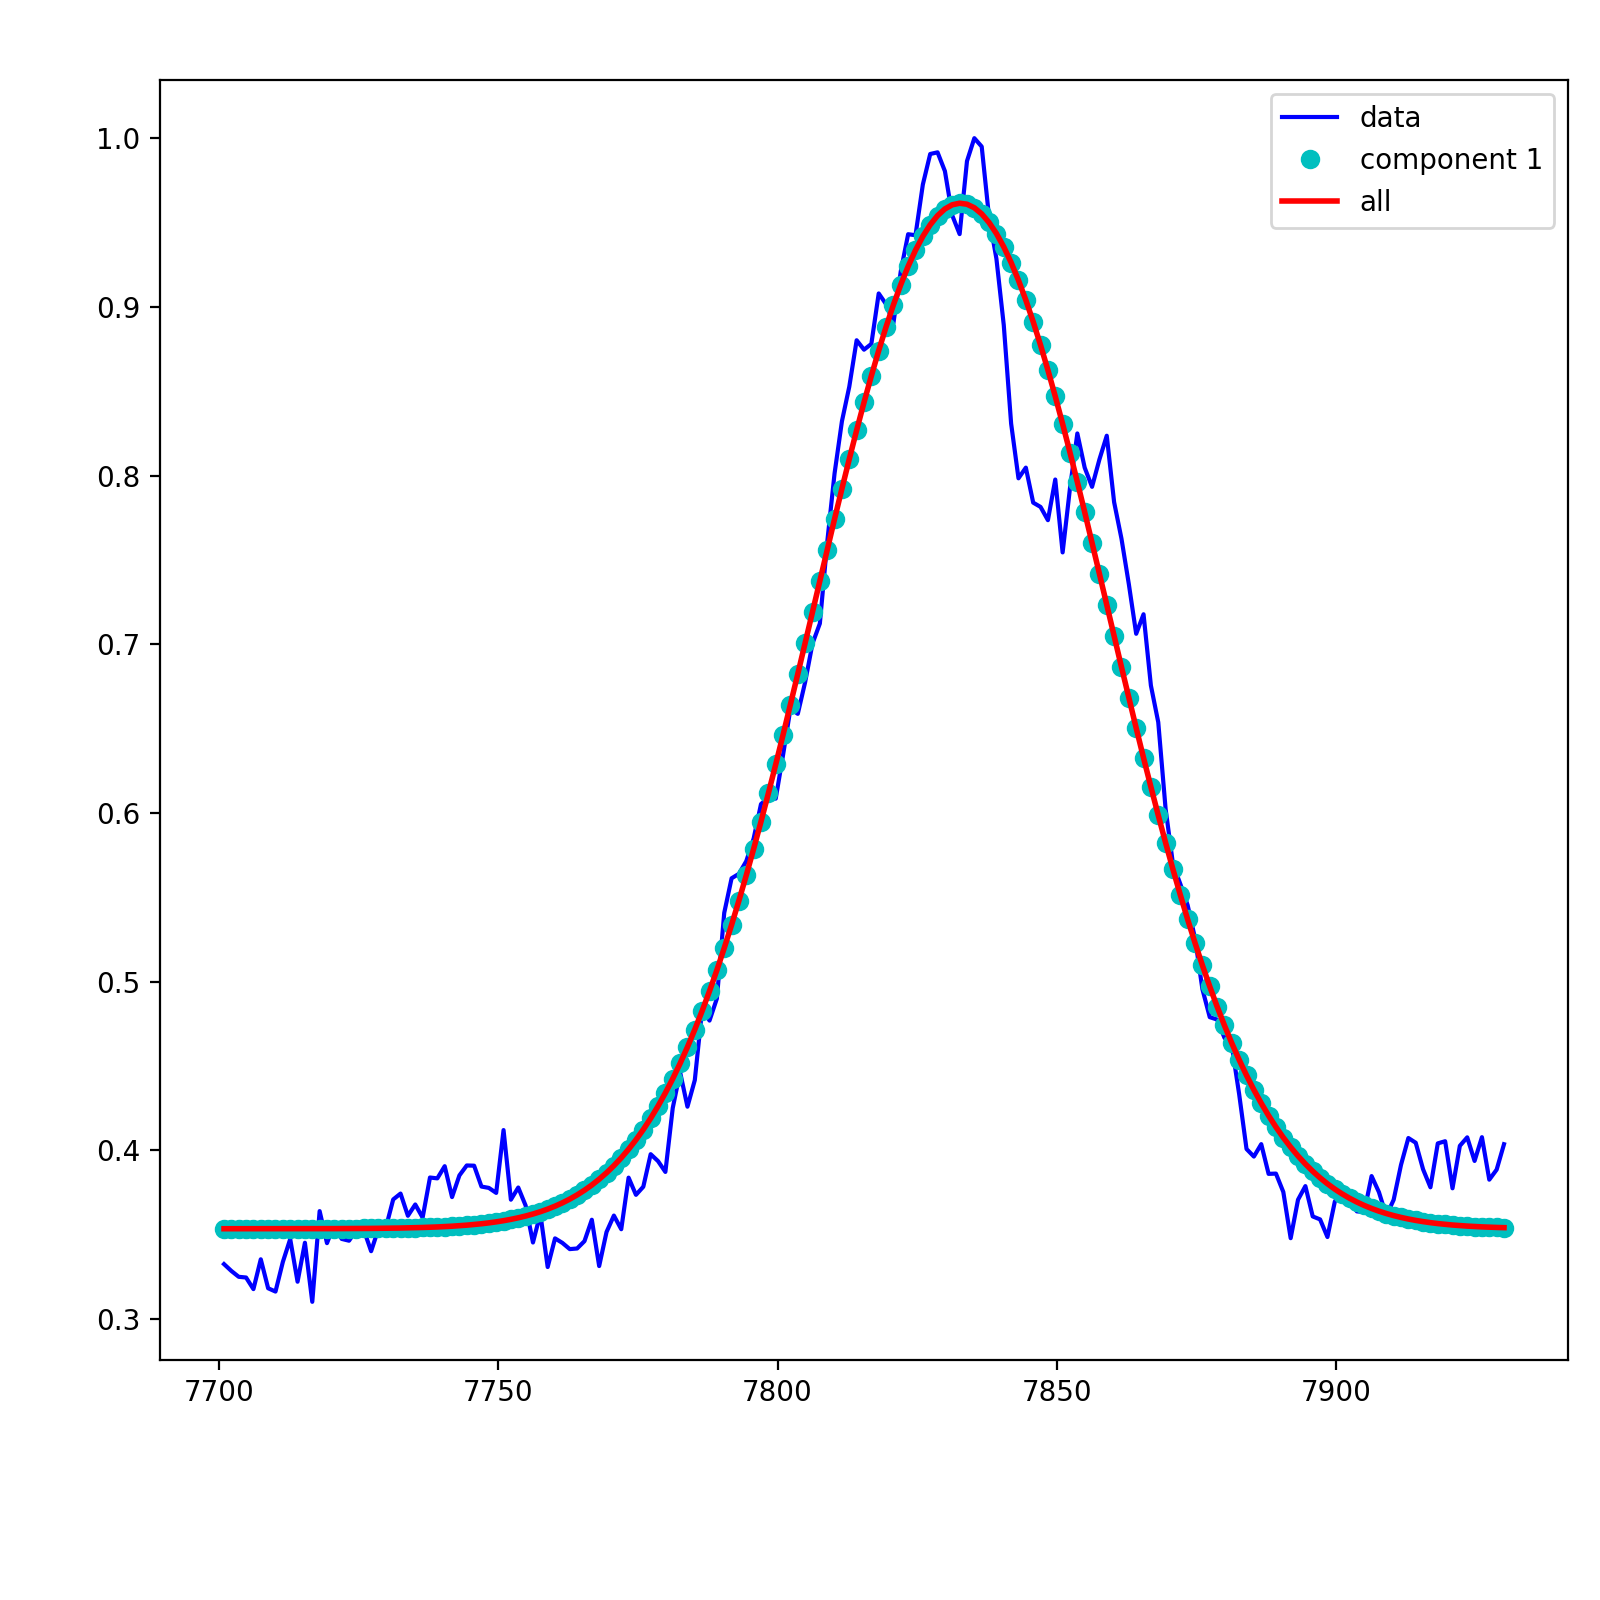

2381.4381270903014
34.46102392590687


In [59]:
specdata = specs_22jli['binospec0120']['spec']
fig,ax = plt.subplots(figsize=(14,8))
ax.plot(specdata[:,0]/(1+z_22jli), specdata[:,1])
ax.set_ylim([-2e-16, 1.5e-15])

plt.tight_layout()


xs = specdata[:,0]
ys = specdata[:,1]
mask = (xs>7700)*(xs<7930)
xfit = xs[mask]
yfit = ys[mask]
normfac  = 1./np.max(yfit)
yfit = yfit*normfac
yerr = 0.1
yerrfit = np.ones_like(xfit)*yerr

params0 = [10, 7780, 40, 0]
spec_1gaussian_fitting(xfit, yfit, yerrfit, params0, display=True, fix_par_inds=None, show_yerr=False, verbose=1)


vfwhm_OI7774_binospec0120 = 26.26*2.35/7774*300000
print(vfwhm_OI7774_binospec0120)
print(0.38*2.35/7774*300000)